<a href="https://colab.research.google.com/github/jaqueline-soares/inpe-cap-paper-01/blob/main/CAP417_ParteC_FinalWork_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAP 417-3 - Part C - Final Work
# **Um estudo de eventos extremos em Petrópolis-RJ através da análise espectral de séries temporais de precipitação**.


Names: 
*   **Alex de A. Fernandes**
*   **Aurelienne A. S. Jorge**
*   **Jaqueline A. J. P. Soares**

Institution: INPE.

Course: PhD in Applied Computing.

Subject: Computational Statistics.

Teacher: Reinaldo Rosa

Date: 09 Jun 2022.

**Bibliotecas e Comandos Necessários:**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import interpolate
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from matplotlib.patches import Polygon
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')
!pip install colorednoise
import colorednoise as cn
#o colorenoise é um típico gerador de ruído baseado na distribuição Gaussiana com lei de potencia. 
#Ref.: Timmer, J. and Koenig, M.: On generating power law noise. Astron. Astrophys. 300, 707-710 (1995) 

# for ggplot and xtick date_breaks and formats.
# plotnine load all packages used for ggplot (grammar of graphics)
!pip install plotnine
from plotnine import *

# mizani used only for datetime breaks and datetime format
!pip install mizani
from mizani.breaks import date_breaks
from mizani.formatters import date_format


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1.Introdução

No dia 15 de fevereiro de 2022, Petrópolis, na Região Serrana do Rio de Janeiro, vivenciou a pior tragéria natural de sua história [1]. Fortes chuvas atingiram a cidade causando inundações, enxurradas e deslizamentos de terra. Como consequência, mais de 220 pessoas morreram, destruindo famílias inteiras [5]. Além das perdas humanas, bairros inteiros foram destruídos, obrigando centenas de pessoas e procurarem pontos de abrigo disponibilizados na cidade.

Para se ter uma ideia da criticidade dessa situação, quase 20% do território de Petrópolis abrange áreas avaliadas como de risco alto e muito alto para deslizamentos, enchentes e inundações, segundo o Plano Municipal de Redução de Riscos, divulgado em 2017 pela prefeitura. De acordo com o estudo, a cidade tem 27.704 moradias em locais de alto e muito alto risco [6]. Isso requer uma atenção especial para essa localidade.

Além do evento extremo de 15 de fevereiro, fortes chuvas foram observadas também em outras datas nesse início do ano de 2022: 29 de janeiro e 20 de março. Dessa forma, as chuvas desses três primeiros meses do ano foram bastante prejudiciais à cidade.

O Centro Nacional de Monitoramento e Alertas de Desastres Naturais (Cemaden) possui uma rede de monitoramento com vários tipos de instrumentos distribuídos em todo o país. Especificamente em Petrópolis-RJ, o Cemaden possui um total de 17 PCDs do tipo Pluviométricas e 4 Geotécnicas.

As Plataformas de Coleta de Dados (PCDs) do Cemaden conseguiram capturar as fortes chuvas ocorridas nesse início de ano, e os dados coletados por esses instrumentos foram utilizados neste trabalho. Através do Mapa Interativo [2], disponibilizado publicamente pelo Cemaden, foram recuperados os dados das PCDs de Petrópolis-RJ nos períodos de janeiro, fevereiro e março de 2022. Os dados do sensor de chuva desses equipamentos foram analisados como séries temporais.

A Figura 1 mostra imagens com sinais de destruição em vários pontos da cidade após a ocorrência da tragédia de 15 de fevereiro de 2022.

In [2]:
def plt_imshow (img, title, axs):
  axs.imshow(img)
  axs.set_title(title) 
  axs.axis("off")

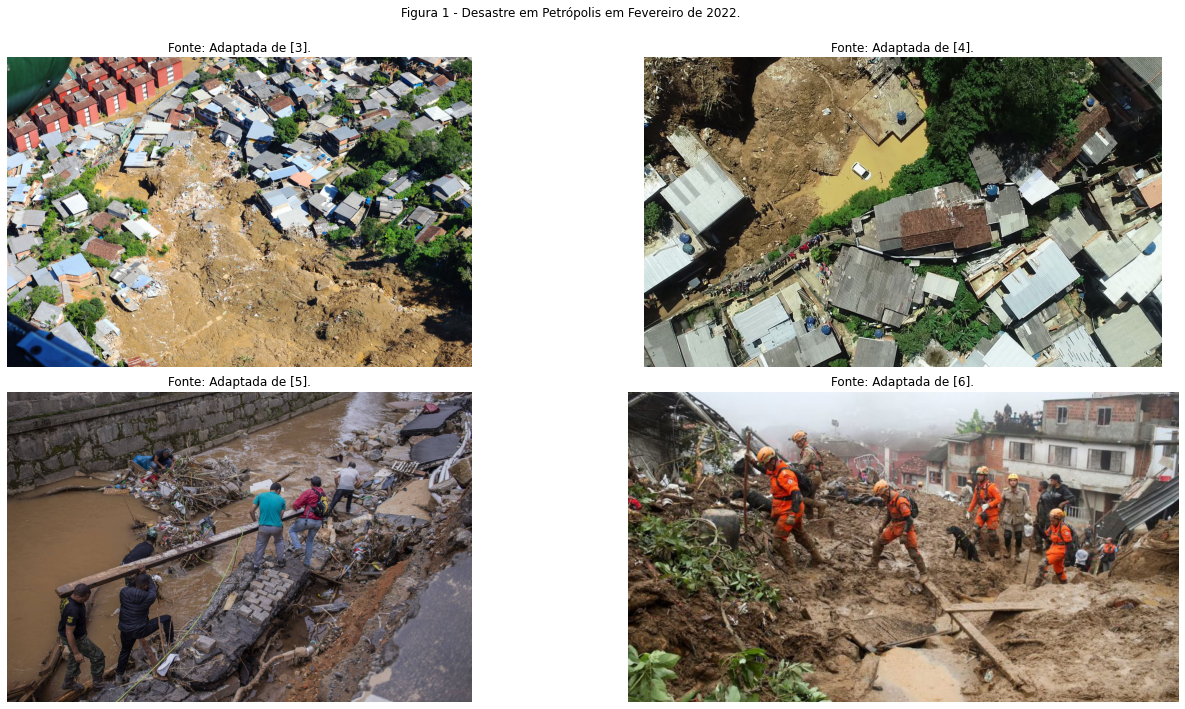

In [3]:
from skimage import io

fig, axs = plt.subplots(2, 2, figsize=(20,10)) #rows = 2, cols = 2

img1 = io.imread("https://s2.glbimg.com/jXK_SGwB1KkToe62Z2YcM6-KS-o=/0x0:3506x2337/1008x0/smart/filters:strip_icc()/i.s3.glbimg.com/v1/AUTH_59edd422c0c84a879bd37670ae4f538a/internal_photos/bs/2022/o/c/7oEEe6QMSIJd7BfMNjNA/000-323b4qb.jpg", 0)
img2 = io.imread("https://imagens.ebc.com.br/tWPtbzulVyNyO8OrJ3oN2uOy_aI=/1170x700/smart/https://agenciabrasil.ebc.com.br/sites/default/files/thumbnails/image/chuva_em_petropolis_tv_brasil_abr_20220217_0203_1.jpg?itok=_PDlV5X4", 0)
img3 = io.imread("https://f.i.uol.com.br/fotografia/2022/02/20/16454075736212ed5565783_1645407573_3x2_lg.jpg", 0)
img4 = io.imread("https://www.istoedinheiro.com.br/wp-content/uploads/sites/17/2022/03/petropolis-768x432.jpg", 0)

#function plt_imshow (img, title, axs, cmap=None)
plt_imshow (img1, "Fonte: Adaptada de [3].", axs[0][0])
plt_imshow (img2, "Fonte: Adaptada de [4].", axs[0][1])
plt_imshow (img3, "Fonte: Adaptada de [5].", axs[1][0])
plt_imshow (img4, "Fonte: Adaptada de [6].", axs[1][1])

fig.suptitle("Figura 1 - Desastre em Petrópolis em Fevereiro de 2022.")

fig.tight_layout()
fig.subplots_adjust(top=0.91)

plt.show()

# 2.Materiais e Métodos

## 2.1. Dados

Foram utilizados os dados do Centro Nacional de Monitoramento e Alertas de Desastres Naturais (Cemaden), disponíveis publicamente através do Mapa Interativo [2]. Esses dados foram salvos e disponibilizados no *github* de forma a facilitar o acesso automático por este trabalho.

Realizou-se um recorte pelos dados provenientes do sensor de *chuva* da estação *Quitandinha - Geo* nos meses de janeiro, fevereiro e março de 2022. Cada um desses meses foi analisado como uma série temporal. 

A estação Quitandinha - Geo foi escolhida por conter uma das maiores taxas de ocorrência de leituras e estar coerente com as leituras dos pluviômetros próximos.

In [4]:
df_2022_01_pluvio = pd.read_csv('https://github.com/jaqueline-soares/inpe-cap-paper-01/blob/main/2022-01-pluvio.csv?raw=True', delimiter=";", decimal=",", index_col=False)
df_2022_02_pluvio = pd.read_csv('https://github.com/jaqueline-soares/inpe-cap-paper-01/blob/main/2022-02-pluvio.csv?raw=True', delimiter=";", decimal=",", index_col=False)
df_2022_03_pluvio = pd.read_csv('https://github.com/jaqueline-soares/inpe-cap-paper-01/blob/main/2022-03-pluvio.csv?raw=True', delimiter=";", decimal=",", index_col=False)
df_pluvio_array = [df_2022_01_pluvio[(df_2022_01_pluvio.nomeEstacao == 'Quitandinha - Geo')]['valorMedida'], 
                   df_2022_02_pluvio[(df_2022_02_pluvio.nomeEstacao == 'Quitandinha - Geo')]['valorMedida'], 
                   df_2022_03_pluvio[(df_2022_03_pluvio.nomeEstacao == 'Quitandinha - Geo')]['valorMedida']]
month_array = ['January 2022', 'February 2022', 'March 2022']

In [5]:
df_2022_01_geo = pd.read_csv('https://github.com/jaqueline-soares/inpe-cap-paper-01/blob/main/2022-01-geo.csv?raw=True', delimiter=";", decimal=",", index_col=False)
df_2022_02_geo = pd.read_csv('https://github.com/jaqueline-soares/inpe-cap-paper-01/blob/main/2022-02-geo.csv?raw=True', delimiter=";", decimal=",", index_col=False)
df_2022_03_geo = pd.read_csv('https://github.com/jaqueline-soares/inpe-cap-paper-01/blob/main/2022-03-geo.csv?raw=True', delimiter=";", decimal=",", index_col=False)
df_geo_array =[df_2022_01_geo, df_2022_02_geo, df_2022_03_geo]

A seguir, amostra dos dados selecionados referente ao mês de Janeiro de 2022.

In [6]:
df_2022_01_pluvio.head()

,municipio,codEstacao,uf,nomeEstacao,longitude,latitude,datahora,valorMedida
0,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,-43.223916,-22.524907,2022-01-01 00:10:00.0,0.0
1,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,-43.223916,-22.524907,2022-01-01 00:20:00.0,0.2
2,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,-43.223916,-22.524907,2022-01-01 01:00:00.0,0.2
3,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,-43.223916,-22.524907,2022-01-01 01:10:00.0,0.2
4,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,-43.223916,-22.524907,2022-01-01 01:40:00.0,0.2


### 2.1.1. Pré-processamento

Devido a periodicidade e a natureza dos dados de chuva, foi necessária uma etapa de pré-processamento antes da utilização efetiva dos mesmos neste trabalho.

Nesta etapa de pré-processamento, destacam-se:

*   Preenchimento das lacunas.
*   Normalização.
*   Adição de ϵ.

**Preenchimento das lacunas**

Os dados provenientes do sensor de chuva das PCDs do Cemaden são enviados a cada 10 minutos em períodos de ocorrência de chuva, e a cada 1 hora em períodos sem chuva. Deste modo, visando a distribuição correta dos dados no tempo, os períodos de 10 em 10 minutos sem dados foram completados com um valor 0.0. 

**Normalização**

Após o preenchimento das lacunas, os dados foram normalizados (média e desvio padrão), de forma a avaliar a diferença de cada valor em relação a média, em termos proporcionais em relação ao desvio padrão.

**Adição de ϵ**

Posteriormente, devido a natureza dos dados de chuva, onde temos grandes períodos com medições zeradas (momentos de não chuva), a série temporal toda foi somada a uma série de ruído branco ϵ, de forma a não afetar a inclinação da reta no PSD e nem a interpretação da série temporal, onde considera-se chuva apenas os valores acima de 1mm.

In [7]:
def normalizeSerie(s):
  serie = s.copy()
  serie = serie-np.average(serie)
  serie = serie/np.std(serie)
  return serie

def insertNaN (df, d1, d2, sub): # Fill NA or NaN with the value of _sub_ argument
                                 # Strings to fill only gap between d1 and d2, format = dd-mm-yyyy, d2= dd-mm-yyyy

  idx = pd.date_range(d1, d2, freq='10min')
  df_result = pd.DataFrame()

#  for var in pd.unique(df.sensor):
  for n in pd.unique(df.nomeEstacao):
    df_temp = df[(df.nomeEstacao == n)]

    lat = df_temp.iloc[0]['latitude']
    lon = df_temp.iloc[0]['longitude']
    cid = df_temp.iloc[0]['codEstacao']
    uf = df_temp.iloc[0]['uf']
    m = df_temp.iloc[0]['municipio']

    idx_temp = df_temp.datahora
    df_temp = df_temp.reset_index()
    df_temp.index = pd.DatetimeIndex(idx_temp)
    df_temp = df_temp.reindex(idx, fill_value = sub)

    #df_temp['valorMedida'] += 0.02 
    #print(df_temp)

    df_temp['nomeEstacao'] = n
    df_temp['latitude'] = lat
    df_temp['longitude'] = lon
    df_temp['codEstacao'] = cid
    df_temp['uf'] = uf
    df_temp['municipio'] = m
    df_temp['valorOriginal'] = df_temp['valorMedida']
    df_temp['valorMedida'] = normalizeSerie(df_temp.valorMedida) # normalized value from column valorMedida

    df_result = pd.concat ([df_temp, df_result])

  df_result['datahora'] = df_result.index
  df_result.index = df_result['datahora']
  return df_result  

def plotST (df, estacao, datai, dataf, sensor, var): # function to plot series from dataframe GEO, that uses a column named _sensor_
  p = ( ggplot ()
     + geom_line (df[(df.datahora >= datai) & 
                     (df.datahora <= dataf) & 
                     (df.sensor == sensor) &
                     (df.nomeEstacao == estacao)],
                 aes('datahora', var, colour='sensor'), 
                 size=0.7, 
                 alpha=0.8)
      + scale_x_datetime(breaks=date_breaks('24 hour'), labels=date_format('%Y%m%d %H:%M'))
      + theme(axis_text_x=element_text(rotation=90, hjust=1), figure_size=(20, 6))
      + facet_wrap ('~ nomeEstacao', ncol=1)
      )
  return p


### 2.1.2. Área de estudo e as estações do Cemaden

A Figura 2 ilustra as estações pluviométricas e geológicas do Cemaden localizadas no município de Petropólis, estando a do Quitandinha localizada mais ao sul do município.

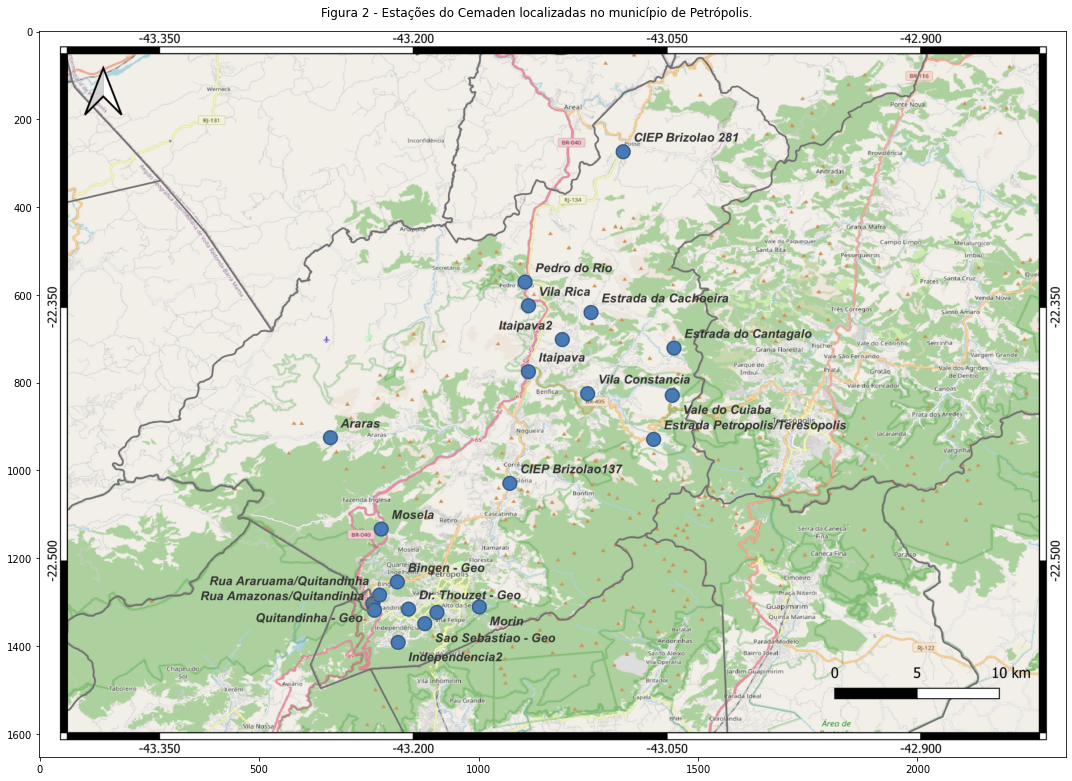

In [8]:
fig = plt.figure(figsize=(15,11))
img = io.imread("https://github.com/aurelienne/data/blob/master/est_petropolis_cemaden.png?raw=true", 0)

plt.imshow (img)
fig.suptitle("Figura 2 - Estações do Cemaden localizadas no município de Petrópolis.")
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()

In [9]:
df_pluvio = pd.concat([df_2022_01_pluvio, df_2022_02_pluvio, df_2022_03_pluvio])
df_pluvio.head()
stations = df_pluvio.groupby(['codEstacao','nomeEstacao','latitude','longitude'])
stations.agg({'valorMedida' : [np.min, np.max, np.mean, np.sum]})

valorMedida  \
                                                                       amin   
codEstacao nomeEstacao                    latitude   longitude                
330390601G Quitandinha - Geo              -22.524907 -43.223916         0.0   
330390602G Chácara Flora - Geo            -22.530270 -43.186073         0.0   
330390603G Dr. Thouzet - Geo              -22.528328 -43.202885         0.0   
330390604G São Sebastião - Geo            -22.536909 -43.193240         0.0   
330390605A Araras                         -22.427000 -43.249000         0.0   
330390605G Bingen - Geo                   -22.512210 -43.209475         0.0   
330390606A Estrada do Cantagalo           -22.374000 -43.046000         0.0   
330390608A Estrada Petrópolis/Teresópolis -22.428000 -43.058000         0.0   
330390609A Vila Constância                -22.401000 -43.097000         0.0   
330390611A Itaipava                       -22.388000 -43.132000         0.0   
330390612A Independência2                 -22.548000 -43.209000         0.0   
330390613A CIEP Brizolão 281              -22.258000 -43.076000         0.0   
330390614A CIEP Brizolão137               -22.454000 -43.143000         0.0   
330390615A Vale do Cuiabá                 -22.402000 -43.047000         0.0   
330390617A Rua Araruama/Quitandinha       -22.520000 -43.220000         0.0   
330390618A Rua Amazonas/Quitandinha       -22.529000 -43.223000         0.0   
330390620A Morin                          -22.527000 -43.161000         0.0   
330390622A Itaipava2                      -22.369000 -43.112000         0.0   
330390623A Pedro do Rio                   -22.335000 -43.134000         0.0   
330390624A Estrada da Cachoeira           -22.353000 -43.095000         0.0   
330390627A Mosela                         -22.481000 -43.219000         0.0   
330390628A Vila Rica                      -22.349000 -43.132000         0.0   

                                                                        \
                                                                  amax   
codEstacao nomeEstacao                    latitude   longitude           
330390601G Quitandinha - Geo              -22.524907 -43.223916  23.40   
330390602G Chácara Flora - Geo            -22.530270 -43.186073  33.00   
330390603G Dr. Thouzet - Geo              -22.528328 -43.202885  30.40   
330390604G São Sebastião - Geo            -22.536909 -43.193240  38.60   
330390605A Araras                         -22.427000 -43.249000   5.51   
330390605G Bingen - Geo                   -22.512210 -43.209475  33.00   
330390606A Estrada do Cantagalo           -22.374000 -43.046000  10.98   
330390608A Estrada Petrópolis/Teresópolis -22.428000 -43.058000   0.00   
330390609A Vila Constância                -22.401000 -43.097000   9.97   
330390611A Itaipava                       -22.388000 -43.132000  11.19   
330390612A Independência2                 -22.548000 -43.209000  28.04   
330390613A CIEP Brizolão 281              -22.258000 -43.076000  10.98   
330390614A CIEP Brizolão137               -22.454000 -43.143000   8.72   
330390615A Vale do Cuiabá                 -22.402000 -43.047000   7.31   
330390617A Rua Araruama/Quitandinha       -22.520000 -43.220000  22.32   
330390618A Rua Amazonas/Quitandinha       -22.529000 -43.223000  17.69   
330390620A Morin                          -22.527000 -43.161000   0.00   
330390622A Itaipava2                      -22.369000 -43.112000   2.17   
330390623A Pedro do Rio                   -22.335000 -43.134000   2.36   
330390624A Estrada da Cachoeira           -22.353000 -43.095000   9.59   
330390627A Mosela                         -22.481000 -43.219000   0.00   
330390628A Vila Rica                      -22.349000 -43.132000  14.60   

                                                                           \
                                                                     mean   
codEstacao nomeEstacao                    latitude   longitude              
330390

In [10]:
df_chuvan0 = insertNaN(df_pluvio, '01-01-2022', '31-03-2022', 0.00)  # inserts 0.0 into dates that there is no data
eps = np.random.normal(0.00, 0.01, len(df_chuvan0['valorMedida'].values))  # creates a white noise series to add to valorMedida
df_chuvan0['valorMedida'] = df_chuvan0['valorMedida'] + eps

df_chuvan0 = df_chuvan0[(df_chuvan0.nomeEstacao == 'Quitandinha - Geo')] # define only Quitandinha - Geo as station to use.

df_2022_01_chuvan0 = df_chuvan0[(df_chuvan0.datahora <= '01-31-2022')] #filter dates to rebuild the original array df_pluvio
df_2022_02_chuvan0 = df_chuvan0[(df_chuvan0.datahora >= '02-01-2022') & (df_chuvan0.datahora <= '03-03-2022')]  
df_2022_03_chuvan0 = df_chuvan0[(df_chuvan0.datahora >= '03-01-2022') & (df_chuvan0.datahora <= '03-31-2022')]  

df_chuvan0_array = [df_2022_01_chuvan0['valorMedida'].values,
                    df_2022_02_chuvan0['valorMedida'].values, 
                    df_2022_03_chuvan0['valorMedida'].values]

df_2022_01_pluvio = df_2022_01_chuvan0  # rebuilds the vectors in df_pluvio with the dates already filled in.
df_2022_02_pluvio = df_2022_02_chuvan0  # rebuilds the vectors in df_pluvio with the dates already filled in.
df_2022_03_pluvio = df_2022_03_chuvan0  # rebuilds the vectors in df_pluvio with the dates already filled in.

df_pluvio_array = df_chuvan0_array 
df_pluvio = df_chuvan0

#for i in range (0, len(df_chuvan0_array)):
#  print (len(df_chuvan0_array[i]))

df_pluvio.describe()

,index,longitude,latitude,valorMedida,valorOriginal
count,12817.000000,1.281700e+04,1.281700e+04,12817.000000,12817.000000
mean,132.158461,-4.322392e+01,-2.252491e+01,0.000086,0.115300
std,280.957389,8.640537e-12,7.098599e-12,0.999974,0.798186
min,0.000000,-4.322392e+01,-2.252491e+01,-0.186025,0.000000
25%,0.000000,-4.322392e+01,-2.252491e+01,-0.150328,0.000000
50%,0.000000,-4.322392e+01,-2.252491e+01,-0.142869,0.000000
75%,0.000000,-4.322392e+01,-2.252491e+01,-0.134590,0.000000
max,1230.000000,-4.322392e+01,-2.252491e+01,29.169026,23.400000


### 2.1.3. Séries Temporais

**Descrição do código:**

A função abaixo será utilizada para plotar as séries temporais do município de Petrópolis-RJ nos meses de janeiro, fevereiro e março de 2022.

In [11]:
def plot_st(dx, dates, title, color, axs):
  axs.set_title(title)
  axs.plot(dx, color=color, linewidth=0.6)
  axs.set_xlabel('dates')
  axs.set_ylabel('precipitation (mm)', fontsize='large')
  axs.axhline(np.std(dx)*3, color='red', label='3*Sigma')
  ax2 = axs.twiny()
  ax2.set_xlabel('time steps')
  ax2.set_xlim(1, len(dx))
  ax2.set_xticks(range(500, len(dx), 500))
  axs.legend() 

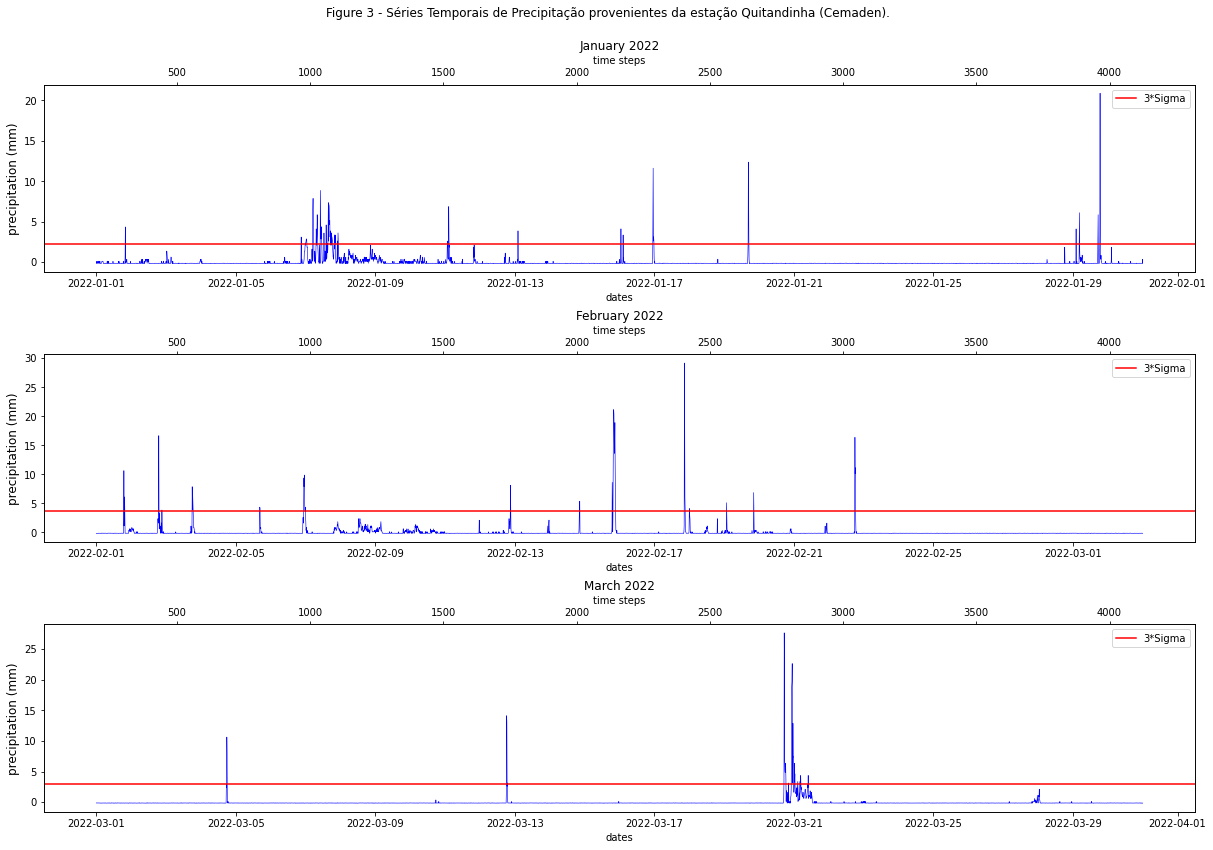

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(17,12)) #rows = 3, cols = 1

plot_st(df_2022_01_pluvio['valorMedida'], df_2022_01_pluvio['datahora'], month_array[0], 'blue', axs[0])
plot_st(df_2022_02_pluvio['valorMedida'], df_2022_02_pluvio['datahora'], month_array[1], 'blue', axs[1])
plot_st(df_2022_03_pluvio['valorMedida'], df_2022_03_pluvio['datahora'], month_array[2], 'blue', axs[2])

fig.suptitle("Figure 3 - Séries Temporais de Precipitação provenientes da estação Quitandinha (Cemaden).")

fig.tight_layout()
fig.subplots_adjust(top=0.89)

plt.show()

## 2.2. Distribuições e caracterização do modelo via Cullen-Frey

In [13]:
def plot_hist(dx, title, axs):
  axs.set_title(title)
  # seaborn histogram with Kernel Density Estimation
  sns.distplot(dx, bins=40, hist_kws={'edgecolor':'black'}, ax=axs)
  axs.set_ylabel('Frequency of A per bin')
  axs.set_xlabel('Blue Bins')

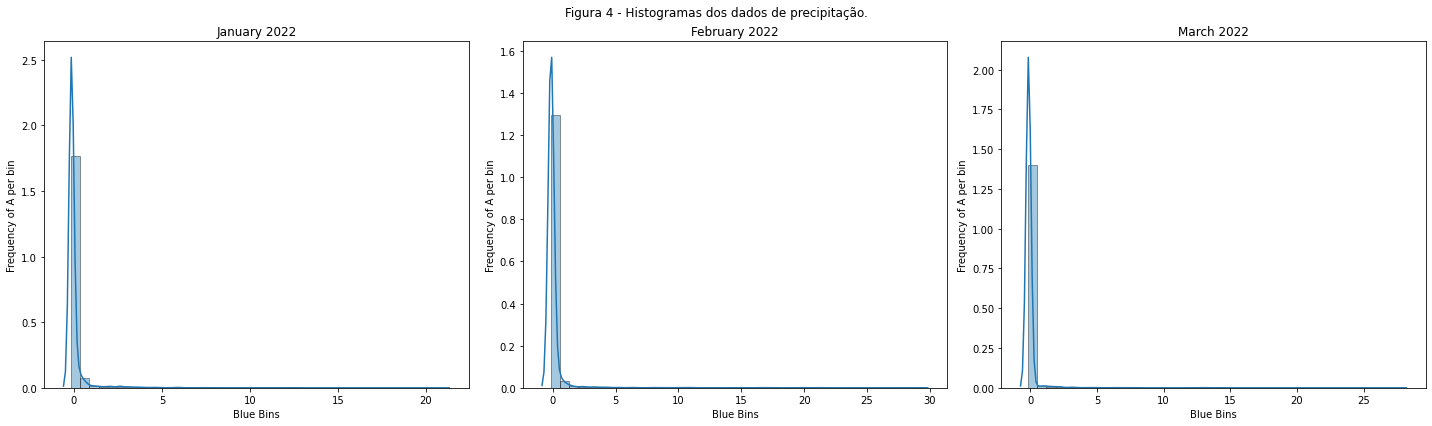

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(20,6)) #rows = 1, cols = 3

for i in range(0, len(df_pluvio_array)):
  plot_hist(df_pluvio_array[i], month_array[i], axs[i])

fig.suptitle("Figura 4 - Histogramas dos dados de precipitação.")

fig.tight_layout()
fig.subplots_adjust(top=0.90)

plt.show()

### 2.2.1. Gráfico de Cullen-Frey (GCF)

**Descrição do código:**

Essa função foi ajustada de forma a melhor atender as necessidades deste Trabalho. Dentre as principais modificações, destacam-se:

*   Inserção da área do GEV no Gráfico de Cullen-Frey;
*   Extrapolação a partir dos pontos do GEV enviado nos slides para plotar o polígono do GEV;
*   Ajuste automático dos novos valores de min e max do gráfico, de acordo com as séries temporais a serem analisadas;
*   Criação de zoom na área do gráfico onde os pontos costumam ficar sobrepostos.

In [15]:
#Espaço de C&F para A
def cullenfrey(A, stParams):
    # Gaussian x Non-Gaussian (The Kullen-Frey Parameter Space)
    m=np.mean(A)
    std=np.std(A)
    s=skew(A)
    k1=kurtosis(A)
    k2=k1+3
    #Parâmetros de Cullen-Frey
    ss=s*s
    k=k2

    # Ploting Cullen-Frey Space
    fig, ax = plt.subplots(figsize=(13,8))

    #Cálculo do X e Y máximos
    y_max = max(stParams['kurtosis']) + 1
    x_max = max(stParams['skewness']) + 1

    maior = x_max
    polyX1 = maior if maior > 4.4 else 4.4
    polyY1 = polyX1 + 1
    polyY2 = 3/2.*polyX1 + 3

    #Beta
    x_beta = [0, polyX1, polyX1, 0]
    y_beta = [1, polyY1, polyY2, 3]
    scale = 1
    poly = Polygon(np.c_[x_beta, y_beta]*scale, facecolor='#1B9AAA', edgecolor='#1B9AAA', alpha=0.5, label='Beta')
    ax.add_patch(poly)

    #GEV
    x1_inter = [0, 4.5]
    y1_inter = [2.25, 6.25]
    f1 = interpolate.interp1d(x1_inter, y1_inter, fill_value='extrapolate')
    x2_inter = [0, 2.15]
    y2_inter = [3, 10]
    f2 = interpolate.interp1d(y2_inter, x2_inter, fill_value='extrapolate')
    x_gev = [0, x_max, x_max, f2(y_max), 0]
    y_gev = [2.25, f1(x_max), y_max, y_max, 3]
    scale = 1
    poly = Polygon(np.c_[x_gev, y_gev]*scale, facecolor='Crimson', edgecolor='Crimson', alpha=0.5, label='GEV')
    ax.add_patch(poly)

    #Séries Temporais de Chuva
    for index, row in stParams.iterrows():
      ax.plot(row['skewness'], row['kurtosis'], marker="o", c="blue", label="Observation - Pluvio", linestyle='')

    #Demais
    ax.plot(0, 3, label="normal (Gaussian)", marker='^', c='magenta')
    #ax.plot(ss, k, marker="o", c="green", label="Gaussian", linestyle='')
    ax.plot(0, 4.187999875999753, label="logistic", marker='+', c='black')
    ax.plot(0, 1.7962675925351856, label ="uniform", marker='*', c='black')
    ax.plot(4, 9, label="exponential", marker='s', c='black')
    ax.plot(np.arange(0, polyX1, 0.1), 3/2. * np.arange(0, polyX1, 0.1) + 3, label="gamma", linestyle='-', c='black')
    ax.plot(np.arange(0, polyX1, 0.1), 2 * np.arange(0, polyX1, 0.1) + 3, label="lognormal", linestyle='-.', c='black')

    ax.grid(which='major', alpha=0.8)
    ax.legend(loc='upper right', fancybox=True, shadow=True)
    ax.set_ylim(y_max, -0.5)
    ax.set_xlim(-0.5, x_max)
    ax.set_xlabel("Skewness²")
    ax.set_ylabel("Kurtosis")
    ax.set_title("Figure 5 - Espaço de parâmetros de Cullen-Frey")

    #Efetua um zoom na área do gráfico onde os pontos ficam sobrepostos
    #axins = zoomed_inset_axes(ax, zoom=2.1, loc='lower left', bbox_to_anchor=(45,0), borderpad=9.6)
    axins = plt.axes([0.15, 0.17, 0.18, 0.18])
    axins.plot(0, 3, label="normal (Gaussian)", marker='^', c='magenta')
    #ax.plot(ss, k, marker="o", c="green", label="Gaussian", linestyle='')
    axins.plot(stParams['skewness'], stParams['kurtosis'], marker="o", c="blue", label="Observation - Endo", linestyle='')
    axins.plot(0, 4.187999875999753, label="logistic", marker='+', c='black')
    axins.plot(0, 1.7962675925351856, label ="uniform", marker='*', c='black')
    axins.plot(4, 9, label="exponential", marker='s', c='black')
    axins.plot(np.arange(0, polyX1, 0.1), 3/2. * np.arange(0, polyX1, 0.1) + 3, label="gamma", linestyle='-', c='black')
    axins.plot(np.arange(0, polyX1, 0.1), 2 * np.arange(0, polyX1, 0.1) + 3, label="lognormal", linestyle='-.', c='black')
    axins.set_ylim(6, -0.5)
    axins.set_xlim(-0.5, 1.5)
    # draw a bbox of the region of the inset axes in the parent axes and
    # connecting lines between the bbox and the inset axes area
    mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="0.5")    

    plt.draw()

In [16]:
def getCFparams(stlist):
  N = len(stlist)
  df = pd.DataFrame(np.zeros((N, 2)),columns = ['kurtosis', 'skewness'])
  for i in range(0, (N)):
    s=skew(stlist[i])
    #Parâmetros de Cullen-Frey
    df['skewness'][i] = s*s
    df['kurtosis'][i] = kurtosis(stlist[i])+3
  return df

In [17]:
def plot_st(dx, samplePlot, title, axs):
  axs.plot(dx[:samplePlot],color='red',label=title)
  axs.set_xlim(0,samplePlot)
  axs.set_title(title)
  axs.legend(loc ="upper left")

def normalizeSerie(s):
  serie = s.copy()
  serie = serie-np.average(serie)
  serie = serie/np.std(serie)
  return serie

**Descrição do código:**

A Figura 3 apresenta a inclusão da área do GEV (em cor-de-rosa) no Gráfico de Cullen-Frey, bem como a plotagem das séries temporais tratadas neste trabalho.

Para isso, foram necessários alguns ajustes na função *'cullenfrey'* definida anteriormente, tais como: ajuste automático para os novos limites de x e y de acordo com os novos dados; reflexo automático disso nas demais séries, para que estas se estendam em toda a área do gráfico; realização de extrapolação linear para que a área do GEV do slide enviado pudesse ser incluída nesse gráfico; criação de zoom na área do gráfico onde os pontos costumam ficar sobrepostos; dentre outros. 

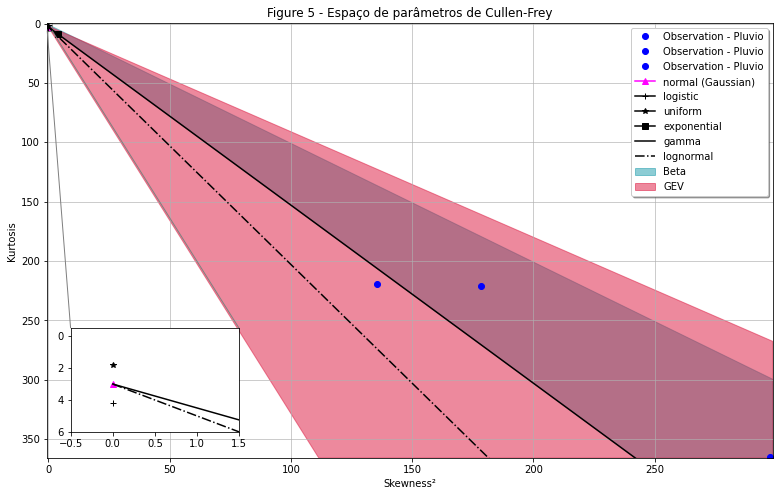

In [18]:
stParams = getCFparams(df_pluvio_array)

maxIndex = np.argmax(stParams['kurtosis'])
cullenfrey(df_pluvio_array[maxIndex], stParams)

plt.show()

**Descrição do código:**

Após a plotagem do Gráfico de Cullen­‐Frey, deve-se analisar com qual das funções cada uma das séries temporais mais se aproxima. Para isso, será calculada a distância entre o ponto que representa a série temporal com as funções apresentadas no Gráfico de Cullen­‐Frey.

O código abaixo mostra a criação de um DataFrame *'df'* com os dados referentes às funções apresentadas no Gráfico de Cullen­‐Frey.

In [19]:
from pandas import DataFrame
from scipy.stats import logistic, uniform, expon, gamma, lognorm, norm

x_max = max(max(stParams['skewness']), max(stParams['skewness'])) + 1
maior = x_max
polyX1 = maior if maior > 4.4 else 4.4

#gamma
x_gamma = np.arange(0, polyX1, 0.1)
y_gamma = 3/2. * np.arange(0, polyX1, 0.1) + 3
coef = np.polyfit(x_gamma, y_gamma, 1)
A_gamma = coef[0]
B_gamma = -1
C_gamma = coef[1]
f_gamma = np.array([A_gamma, B_gamma, C_gamma])

#lognormal
x_lognormal = np.arange(0, polyX1, 0.1)
y_lognormal = 2 * np.arange(0, polyX1, 0.1) + 3
coef = np.polyfit(x_lognormal, y_lognormal, 1)
A_lognormal = coef[0]
B_lognormal = -1
C_lognormal = coef[1]
f_lognormal = np.array([A_lognormal, B_lognormal, C_lognormal])

#Criação do DataFrame
dict = {
    'name': ['normal', 'logistic', 'uniform', 'exponential', 'gamma', 'lognormal'],
    'PDF': [norm, logistic, uniform, expon, gamma, lognorm],
    'data': [np.array([0,3]), np.array([0, 4.187999875999753]), np.array([0, 1.7962675925351856]), np.array([4, 9]), f_gamma, f_lognormal]
    }
df = DataFrame(data=dict)
df.head(6)

,name,PDF,data
0,normal,<scipy.stats._continuous_distns.norm_gen objec...,"[0, 3]"
1,logistic,<scipy.stats._continuous_distns.logistic_gen o...,"[0.0, 4.187999875999753]"
2,uniform,<scipy.stats._continuous_distns.uniform_gen ob...,"[0.0, 1.7962675925351856]"
3,exponential,<scipy.stats._continuous_distns.expon_gen obje...,"[4, 9]"
4,gamma,<scipy.stats._continuous_distns.gamma_gen obje...,"[1.4999999999999998, -1.0, 2.9999999999999787]"
5,lognormal,<scipy.stats._continuous_distns.lognorm_gen ob...,"[2.0000000000000004, -1.0, 2.9999999999999623]"


**Descrição do código:**

A função abaixo calcula a distância do ponto recebido como parâmetro para cada uma das funções apresentadas no Gráfico de Cullen­‐Frey (DataFrame *'df'*), e retorna o índice no DataFrame da função com a menor distância, ou seja, a que mais se aproxima do ponto em questão.

Essa função foi implementada para que a verificação fosse realizada de forma automática e precisa, independente de análise manual.

In [20]:
from math import sqrt 

#Function to find distance from Point to a Line
def shortest_distance_point_line(x, y, a, b, c):      
    return abs((a * x + b * y + c)) / (sqrt(a * a + b * b))    

def get_closest_function(point_st):
  distance_array = []
  for index, row in df.iterrows():
    if len(row['data']) == 2:
      #Calculate the Euclidean distance
      distance = np.linalg.norm(point_st - row['data'])
    else:
      distance = shortest_distance_point_line(point_st[0], point_st[1], row['data'][0], row['data'][1], row['data'][2])
    distance_array.append(distance)
    print("   '{}': {}".format(row['name'], distance))
  return np.argmin(distance_array) 

**Descrição do código:**

O código abaixo obtém o modelo caracterizado a partir do Gráfico de Cullen­‐Frey para cada uma das séries temporais referenciadas neste trabalho.

In [21]:
print('Séries provenientes do Processo Browniano Gaussiano:\n')

print('-------------{}-------------'.format(month_array[0]))
print('Cálculo das Distâncias:')
point1_st = [stParams['skewness'][0], stParams['kurtosis'][0]]
index1_st = get_closest_function(point1_st)
print('\nModelo selecionado:', df['name'][index1_st])
print('-------------{}-------------\n'.format(month_array[0]))

print('-------------{}-------------'.format(month_array[1]))
print('Cálculo das Distâncias:')
point2_st = [stParams['skewness'][1], stParams['kurtosis'][1]]
index2_st = get_closest_function(point2_st)
print('\nModelo selecionado:', df['name'][index2_st])
print('-------------{}-------------\n'.format(month_array[1]))

print('-------------{}-------------'.format(month_array[2]))
print('Cálculo das Distâncias:')
point3_st = [stParams['skewness'][2], stParams['kurtosis'][2]]
index3_st = get_closest_function(point3_st)
print('\nModelo selecionado:', df['name'][index3_st])
print('-------------{}-------------\n'.format(month_array[2]))

Séries provenientes do Processo Browniano Gaussiano:

-------------January 2022-------------
Cálculo das Distâncias:
   'normal': 255.00203548622363
   'logistic': 253.9963847252375
   'uniform': 256.02259753263905
   'exponential': 247.79380818665126
   'gamma': 7.09783318035291
   'lognormal': 24.573832177213305

Modelo selecionado: gamma
-------------January 2022-------------

-------------February 2022-------------
Cálculo das Distâncias:
   'normal': 281.9658741410171
   'logistic': 281.04692157016376
   'uniform': 282.89904005963484
   'exponential': 274.789604783392
   'gamma': 27.326485595455303
   'lognormal': 61.924399946966446

Modelo selecionado: gamma
-------------February 2022-------------

-------------March 2022-------------
Cálculo das Distâncias:
   'normal': 468.55583027421784
   'logistic': 467.6389460609082
   'uniform': 469.48609643653936
   'exponential': 461.3815629392443
   'gamma': 46.93546371155312
   'lognormal': 104.39790756534032

Modelo selecionado: gamma

**Descrição do código:**

A função abaixo será utilizada para plotar o histograma referente a cada uma das séries temporais referenciadas neste trabalho.

In [22]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def plot_hist(dx, title, color, axs, fit, label):
  axs.set_title("{} - {}".format(title, label))
  sns.distplot(dx, hist_kws={'edgecolor':'black'}, fit_kws={'color': 'red', 'alpha': .85, 'label': label}, color=color, ax=axs, fit=fit, kde=False)
  axs.set_ylabel('Frequency per bin')
  axs.set_xlabel('Bins')
  axs.legend(loc ="upper right")

**Descrição do código:**

A Figura 4 mostra o histograma para cada uma das séries referenciadas neste trabalho, bem como o ajuste sobre o histograma de acordo com o modelo caracterizado a partir do Gráfico de Cullen­‐Frey.

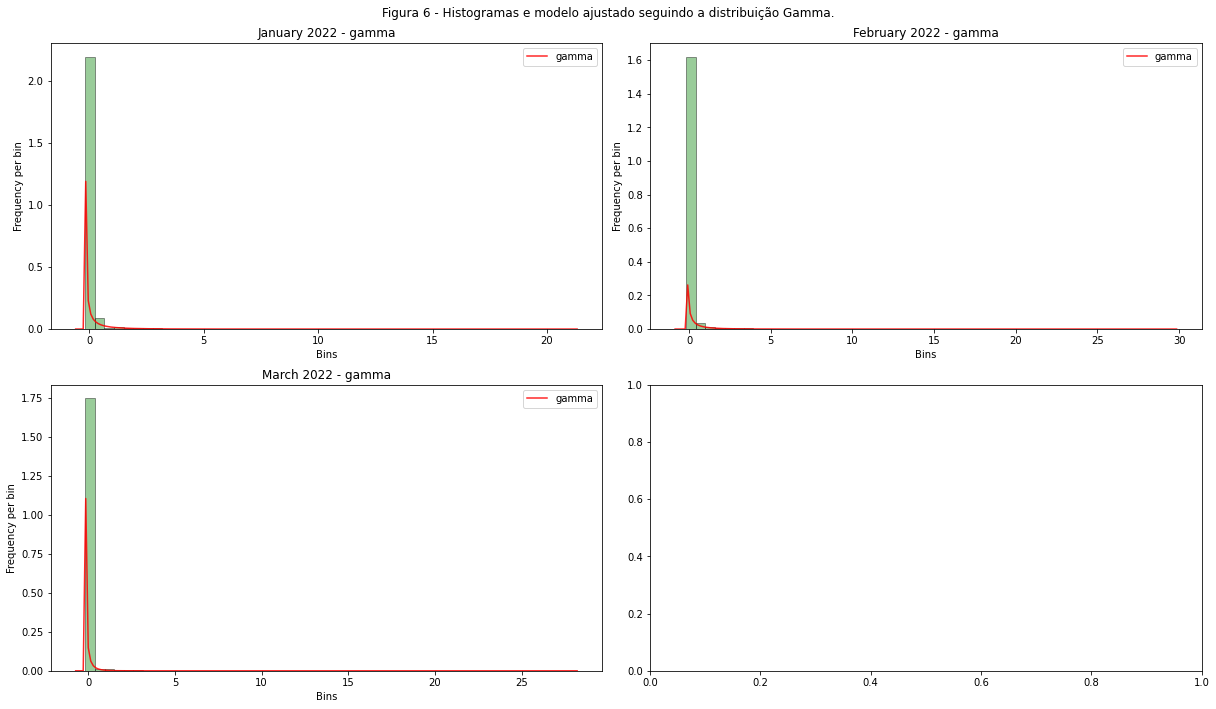

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(17,10)) #rows = 2, cols = 2

color = 'g'

plot_hist(df_pluvio_array[0], month_array[0], color, axs[0][0], df['PDF'][index1_st], df['name'][index1_st])
plot_hist(df_pluvio_array[1], month_array[1], color, axs[0][1], df['PDF'][index2_st], df['name'][index2_st])
plot_hist(df_pluvio_array[2], month_array[2], color, axs[1][0], df['PDF'][index3_st], df['name'][index3_st])

fig.suptitle("Figura 6 - Histogramas e modelo ajustado seguindo a distribuição Gamma.")

fig.tight_layout()
fig.subplots_adjust(top=0.93)

plt.show()

## 2.3. Caracterização do Espectro de Potências (via PSD e DFA)

SPECPLUS.PY (processamento de apenas 01 módulo google colab para obter o output).

Obtem os espectros PSD (power spctrum density) e DFA (dentreded fluctuation analysis) para uma série temporal com $2ˆ{n}$ pontos.

**Descrição do código:**

O código abaixo foi modificado em alguns trechos de forma a atender aos requisitos deste trabalho. As principais mudanças consistiram em: 

*   Foi alterada a função *main* para receber como parâmetro uma série temporal;
*   Foi alterada a chamada da função *main* para ficar em blocos sequenciais de código, de forma a plotar os gráficos para as três séries temporais geradas por esse trabalho;
*   Foram ajustados os valores de INICIO e FIM da função *psd* de forma a se adequarem às séries temporais geradas neste trabalho.

In [24]:
# ------------------------------------------------------------------------
# SpecplusV01.py
# ------------------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats, optimize
import numpy as np
import math

__author__ = 'Paulo Giovani'
__copyright__ = 'Copyright 2017, 3DBMO Project INPE'
__credits__ = ['Paulo Giovani', 'Reinaldo Roberto Rosa', 'Murilo da Silva Dantas']
__license__ = 'GPL'
__version__ = '0.1B'
__maintainer__ = 'Paulo Giovani'
__email__ = 'pg_faria@yahoo.com.br'

#---------------------------------------------------------------------
# Calcula o PSD da série temporal
#---------------------------------------------------------------------
def psd(data, INICIO=10, FIM=1200):
	"""Calcula o PSD de uma série temporal."""
	
	# Define um intervalo para realizar o ajuste da reta
	#INICIO = 10
	#FIM = 1200
	
	# O vetor com o tempo é o tamanho do número de pontos
	N = len(data)
	tempo = np.arange(len(data))

	# Define a frequência de amostragem
	dt = (tempo[-1] - tempo[0] / (N - 1))
	fs = 1 / dt

	# Calcula o PSD utilizando o MLAB
	power, freqs = mlab.psd(data, Fs = fs, NFFT = N, scale_by_freq = False)

	# Calcula a porcentagem de pontos utilizados na reta de ajuste
	totalFrequencias = len(freqs)
	totalPSD = FIM - INICIO
	porcentagemPSD = int(100 * totalPSD / totalFrequencias)

	# Seleciona os dados dentro do intervalo de seleção
	xdata = freqs[INICIO:FIM]
	ydata = power[INICIO:FIM]

	# Simula o erro
	yerr = 0.2 * ydata

	# Define uma função para calcular a Lei de Potência
	powerlaw = lambda x, amp, index: amp * (x**index)

	# Converte os dados para o formato LOG
	logx = np.log10(xdata)
	logy = np.log10(ydata)

	# Define a função para realizar o ajuste
	fitfunc = lambda p, x: p[0] + p[1] * x
	errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err    
	logyerr = yerr / ydata

	# Calcula a reta de ajuste
	pinit = [1.0, -1.0]
	out = optimize.leastsq(errfunc, pinit, args = (logx, logy, logyerr), full_output = 1)    
	pfinal = out[0]
	covar = out[1]
	index = pfinal[1]
	amp = 10.0 ** pfinal[0]
	indexErr = np.sqrt(covar[0][0])
	ampErr = np.sqrt(covar[1][1]) * amp
	
	# Retorna os valores obtidos
	return freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM
	
#---------------------------------------------------------------------
# Calcula o DFA 1D da série temporal
#---------------------------------------------------------------------
def dfa1d(timeSeries, grau):
	"""Calcula o DFA 1D (adaptado de Physionet), onde a escala cresce
	de acordo com a variável 'Boxratio'. Retorna o array 'vetoutput', 
	onde a primeira coluna é o log da escala S e a segunda coluna é o
	log da função de flutuação."""

	# 1. A série temporal {Xk} com k = 1, ..., N é integrada na chamada função perfil Y(k)
	x = np.mean(timeSeries)
	timeSeries = timeSeries - x
	yk = np.cumsum(timeSeries)
	tam = len(timeSeries)

	# 2. A série (ou perfil) Y(k) é dividida em N intervalos não sobrepostos de tamanho S
	sf = np.ceil(tam / 4).astype(np.int)
	boxratio = np.power(2.0, 1.0 / 8.0)
	vetoutput = np.zeros(shape = (1,2))

	s = 4
	while s <= sf:        
		serie = yk        
		if np.mod(tam, s) != 0:
			l = s * int(np.trunc(tam/s))
			serie = yk[0:l]			
		t = np.arange(s, len(serie), s)
		v = np.array(np.array_split(serie, t))
		l = len(v)
		x = np.arange(1, s + 1)
		
		# 3. Calcula-se a variância para cada segmento v = 1,…, n_s:
		p = np.polynomial.polynomial.polyfit(x, v.T, grau)
		yfit = np.polynomial.polynomial.polyval(x, p)
		vetvar = np.var(v - yfit)
		
		# 4. Calcula-se a função de flutuação DFA como a média das variâncias de cada intervalo
		fs = np.sqrt(np.mean(vetvar))
		vetoutput = np.vstack((vetoutput,[s, fs]))
		
		# A escala S cresce numa série geométrica
		s = np.ceil(s * boxratio).astype(np.int)

	# Array com o log da escala S e o log da função de flutuação   
	vetoutput = np.log10(vetoutput[1::1,:])

	# Separa as colunas do vetor 'vetoutput'
	x = vetoutput[:,0]
	y = vetoutput[:,1]

	# Regressão linear
	slope, intercept, _, _, _ = stats.linregress(x, y)

	# Calcula a reta de inclinação
	predict_y = intercept + slope * x

	# Calcula o erro
	pred_error = y - predict_y

	# Retorna o valor do ALFA, o vetor 'vetoutput', os vetores X e Y,
	# o vetor com os valores da reta de inclinação e o vetor de erros
	return slope, vetoutput, x, y, predict_y, pred_error

#---------------------------------------------------------------------
# Trecho principal
#---------------------------------------------------------------------
def main(data):
	"""Função com o código princiapl do programa."""
	
	print("\nData Analysis for 3DBMO simulations...\n")
	
	# Desabilita as mensagens de erro do Numpy (warnings)
	old_settings = np.seterr(divide = 'ignore', invalid = 'ignore', over = 'ignore')
	
	# Exibe os primeiro N valores do arquivo
	N = 10
	print("Original time series data (%d points): \n" %(len(data)))
	print("First %d points: \n%s" %(N, data[0:10]))
	print()
	
	#-----------------------------------------------------------------
  # Parâmetros gerais de plotagem
  #-----------------------------------------------------------------
	
	# Define os subplots
	fig = plt.figure()
	fig.subplots_adjust(hspace = .3, wspace = .2)
	
	# Tamanho das fontes
	tamanhoFonteEixoX = 16
	tamanhoFonteEixoY = 16
	tamanhoFonteTitulo = 16
	tamanhoFontePrincipal = 25
	
	# Título principal
	tituloPrincipal = 'Spectral Time Series Analysis' 	
	
	#-----------------------------------------------------------------
  # Plotagem da série original
  #-----------------------------------------------------------------
	
	# Define as cores da plotagem
	corSerieOriginal = 'r'
	
	# Título dos eixos da série original
	textoEixoX = 'Tempo'
	textoEixoY = 'Amplitude'
	textoTituloOriginal = 'Original Time Series Data'
	
	print("1. Plotting time series data...")
	
	# Plotagem da série de dados    
	#O = fig.add_subplot(1, 3, 1)    
	O = fig.add_subplot(2, 1, 1)
	O.plot(data, '-', color = corSerieOriginal)
	O.set_title(textoTituloOriginal, fontsize = tamanhoFonteTitulo)
	O.set_xlabel(textoEixoX, fontsize = tamanhoFonteEixoX)
	O.set_ylabel(textoEixoY, fontsize = tamanhoFonteEixoY)
	O.ticklabel_format(style = 'sci', axis = 'x', scilimits = (0,0))
	O.grid()
	
	#-----------------------------------------------------------------
  # Cálculo e plotagem do PSD
  #-----------------------------------------------------------------
	
	# Calcula o PSD
	freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM = psd(data)

	# O valor do beta equivale ao index
	b = index

	# Define as cores da plotagem
	corPSD1 = 'k'
	corPSD2 = 'navy'

	# Título dos eixos do PSD
	textoPSDX = 'Frequência (Hz)'
	textoPSDY = 'Potência'
	textoTituloPSD = r'Power Spectrum Density $\beta$ = '
	
	print("2. Plotting Power Spectrum Density...")

	# Plotagem do PSD    
	PSD = fig.add_subplot(2, 2, 3)    
	PSD.plot(freqs, power, '-', color = corPSD1, alpha = 0.7)
	PSD.plot(xdata, ydata, color = corPSD2, alpha = 0.8)
	PSD.axvline(freqs[INICIO], color = corPSD2, linestyle = '--')
	PSD.axvline(freqs[FIM], color = corPSD2, linestyle = '--')    
	PSD.plot(xdata, powerlaw(xdata, amp, index), 'r-', linewidth = 1.5, label = '$%.4f$' %(b))    
	PSD.set_xlabel(textoPSDX, fontsize = tamanhoFonteEixoX)
	PSD.set_ylabel(textoPSDY, fontsize = tamanhoFonteEixoY)
	PSD.set_title(textoTituloPSD + '%.4f' %(b), loc = 'center', fontsize = tamanhoFonteTitulo)
	PSD.set_yscale('log')
	PSD.set_xscale('log')
	PSD.grid() 
	
	#-----------------------------------------------------------------
	# Cálculo e plotagem do DFA
  #-----------------------------------------------------------------
	        
	# Calcula o DFA 1D
	alfa, vetoutput, x, y, reta, erro = dfa1d(data, 1)

	# Verifica se o DFA possui um valor válido
	# Em caso afirmativo, faz a plotagem
	if not math.isnan(alfa):
		
		# Define as cores da plotagem
		corDFA = 'darkmagenta'

		# Título dos eixos do DFA
		textoDFAX = '$log_{10}$ (s)'
		textoDFAY = '$log_{10}$ F(s)'
		textoTituloDFA = r'Detrended Fluctuation Analysis $\alpha$ = '
		
		print("3. Plotting Detrended Fluctuation Analysis...")
		
		# Plotagem do DFA 
		DFA = fig.add_subplot(2, 2, 4)    
		DFA.plot(x, y, 's', 
				 color = corDFA, 
				 markersize = 4,
				 markeredgecolor = 'r',
				 markerfacecolor = 'None',
				 alpha = 0.8)				 
		DFA.plot(x, reta, '-', color = corDFA, linewidth = 1.5)
		DFA.set_title(textoTituloDFA + '%.4f' %(alfa), loc = 'center', fontsize = tamanhoFonteTitulo)
		DFA.set_xlabel(textoDFAX, fontsize = tamanhoFonteEixoX)
		DFA.set_ylabel(textoDFAY, fontsize = tamanhoFonteEixoY)
		DFA.grid()

	else: 
		textoTituloDFA = r'Detrended Fluctuation Analysis $\alpha$ = '
		DFA = fig.add_subplot(2, 2, 4)
		DFA.set_title(textoTituloDFA + 'N.A.', loc = 'center', fontsize = tamanhoFonteTitulo)
		DFA.grid()

	#-----------------------------------------------------------------
	# Exibe e salva a figura
	#-----------------------------------------------------------------
	plt.suptitle(tituloPrincipal, fontsize = tamanhoFontePrincipal)
	nomeImagem = '3DBMO_PSD_DFA_2.png'
	fig.set_size_inches(15, 9)
	plt.savefig(nomeImagem, dpi = 300, bbox_inches = 'tight', pad_inches = 0.1)	
	plt.show()



#################### Time series of January 2022 ####################

Data Analysis for 3DBMO simulations...

Original time series data (4321 points): 

First 10 points: 
[-0.14357409 -0.13636688  0.10305833 -0.15040851 -0.14737713 -0.14382318
  0.09190626  0.11056939 -0.14393441 -0.13042182]

1. Plotting time series data...
2. Plotting Power Spectrum Density...
3. Plotting Detrended Fluctuation Analysis...


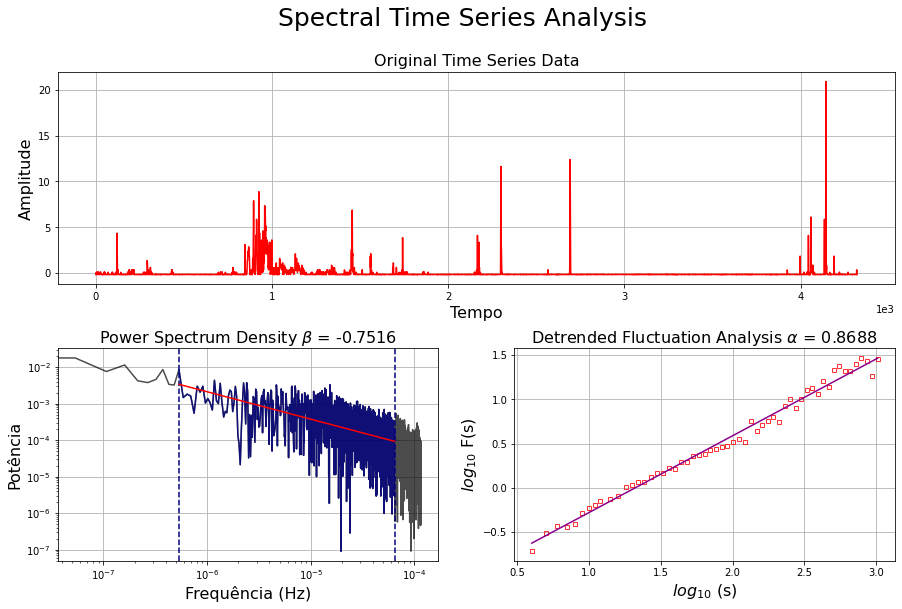



#################### Time series of February 2022 ####################

Data Analysis for 3DBMO simulations...

Original time series data (4321 points): 

First 10 points: 
[-0.15521614 -0.15320179 -0.15191213 -0.15050315 -0.14838842 -0.1410669
 -0.13950652 -0.15913769 -0.15901882 -0.13176436]

1. Plotting time series data...
2. Plotting Power Spectrum Density...
3. Plotting Detrended Fluctuation Analysis...


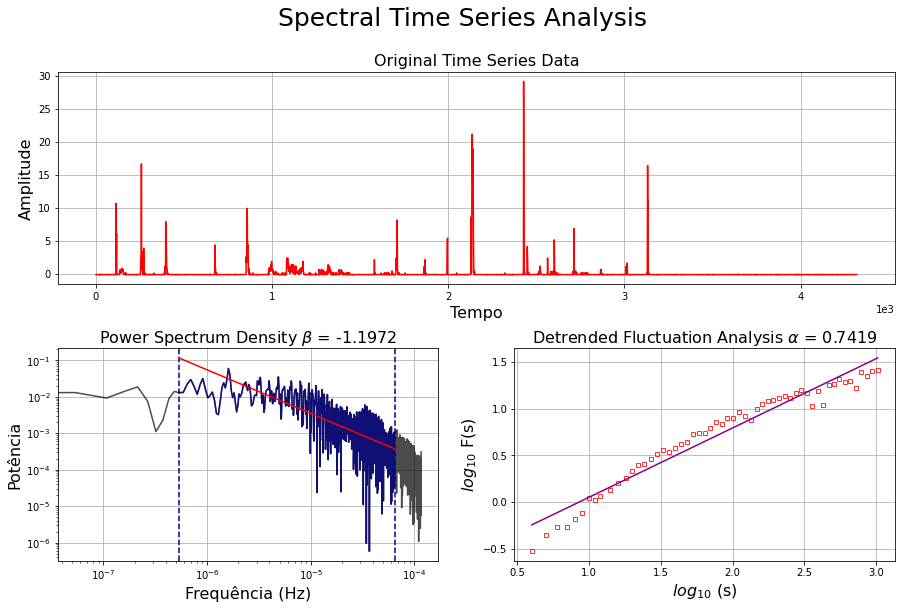



#################### Time series of March 2022 ####################

Data Analysis for 3DBMO simulations...

Original time series data (4321 points): 

First 10 points: 
[-0.12920708 -0.13605172 -0.127125   -0.14380766 -0.13416109 -0.13351341
 -0.13332118 -0.12670401 -0.1286497  -0.13604176]

1. Plotting time series data...
2. Plotting Power Spectrum Density...
3. Plotting Detrended Fluctuation Analysis...


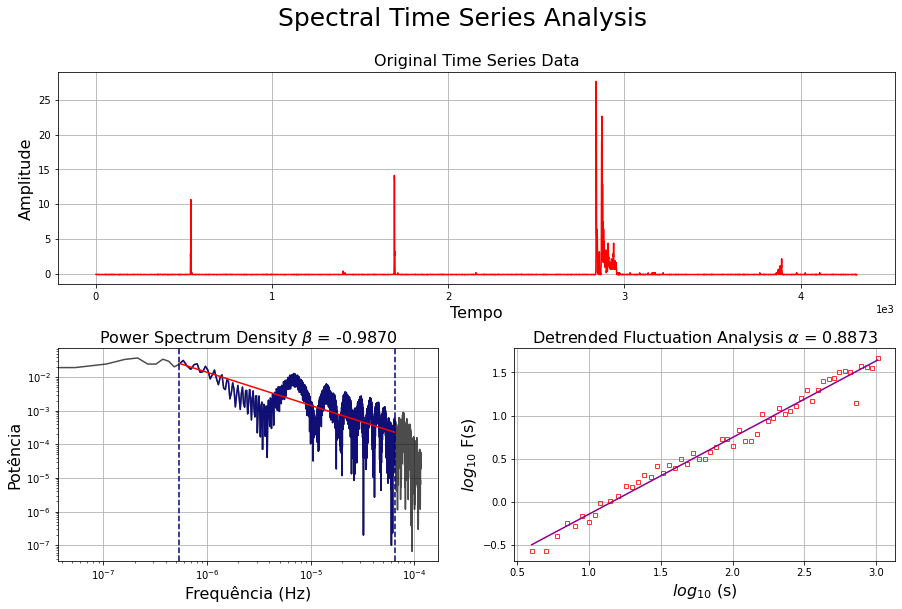

In [25]:
for i in range(0, len(df_pluvio_array)):
  print("\n\n#################### Time series of {} ####################".format(month_array[i]))
  main(df_pluvio_array[i])

**Descrição do código:**

As funções abaixo são utilizadas no cálculo de $γ_1$ para uma dada série temporal recebida como entrada.

In [26]:
def getPSDBeta(data):
  # Calcula o PSD
	freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM = psd(data, 5, 80)
	# O valor do beta equivale ao index
	return index

def getDFAAlfa(data): 
 	# Calcula o DFA 1D
	alfa, vetoutput, x, y, reta, erro = dfa1d(data, 1)
	return alfa
  
def calc_gamma1(data):
  return 2/7 * (getDFAAlfa(data) - getPSDBeta(data))

## 2.4. Caracterização do espectro multifractal (via MFSS)

A seguir o algoritmo MFDFA.py é aplicado sobre as séries temporais para obtenção do espectro multifractal de singularidade (MFSS).

MFSS-MÓDULO A 

In [27]:
#MFDFA-Analytics-by-SKDataScience
#multifractal DFA singularity spectra - module A
#Version 3.0 - Modified by R.R.Rosa - Dec 2018 - mfdfa_ss_m1.py
# This code implements a modification of the first-order unifractal analysis algorithm originally described in [1].
# It covers both the detrended fluctuation analysis (DFA) and the Hurst (a.k.a. R/S) analysis methods. For more details
# on the DFA and Hurst analysis methods, please refer to [2, 3].
#
# At the input, 'dx' is a time series of increments of the physical observable 'x(t)', of the length equal to an
# integer power of two greater than two (i.e. 4, 8, 16, 32, etc.), 'normType_p' is any real greater than or
# equal to one specifying the p-norm, 'isDFA' is a boolean value prescribing to use either the DFA-based algorithm or
# the standard Hurst (a.k.a. R/S) analysis, 'normType_q' is any real greater than or equal to one specifying the q-norm.
#
# At the output, 'timeMeasure' is the time measure of the data's support at different scales, 'meanDataMeasure' is
# the data measure at different scales, while 'scales' is the scales at which the data measure is computed.
#
# The conventional way of using the output values is to plot the data measure vs the scales; the time measure,
# being the inverse quantity to the scales, is computed for an alternative representation and may be ignored.
#
# The requirement to have a power-of-two data length is aimed at avoiding inaccuracies when computing the data measure
# on different time scales.
#
# REFERENCES:
# [1] D.M. Filatov, J. Stat. Phys., 165 (2016) 681-692. DOI: 10.1007/s10955-016-1641-6.
# [2] J.W. Kantelhardt, Fractal and Multifractal Time Series, available at http://arxiv.org/abs/0804.0747, 2008.
# [3] J. Feder, Fractals, Plenum Press, New York, 1988.
#
# The end user is granted perpetual permission to reproduce, adapt, and/or distribute this code, provided that
# an appropriate link is given to the original repository it was downloaded from.

#input: read your time series as a 1d vector, with size 2ˆn, named:  dx

import numpy as np

def getHurstByUpscaling(dx, normType_p = np.inf, isDFA = 1, normType_q = 1.0):
    ## Some initialiation
    dx_len = len(dx)

    # We have to reserve the most major scale for shifts, so we divide the data
    # length by two. (As a result, the time measure starts from 2.0, not from
    # 1.0, see below.)
    dx_len = np.int(dx_len / 2)

    dx_shift = np.int(dx_len / 2)

    nScales = np.int(np.round(np.log2(dx_len)))    # Number of scales involved. P.S. We use 'round()' to prevent possible malcomputing of the logarithms
    j = 2 ** (np.arange(1, nScales + 1) - 1) - 1

    meanDataMeasure = np.zeros(nScales)

    ## Computing the data measure
    for ji in range(1, nScales + 1):
        # At the scale 'j(ji)' we deal with '2 * (j(ji) + 1)' elements of the data 'dx'
        dx_k_len = 2 * (j[ji - 1] + 1)
        n = np.int(dx_len / dx_k_len)

        dx_leftShift = np.int(dx_k_len / 2)
        dx_rightShift = np.int(dx_k_len / 2)

        for k in range(1, n + 1):
            # We get a portion of the data of the length '2 * (j(ji) + 1)' plus the data from the left and right boundaries
            dx_k_withShifts = dx[(k - 1) * dx_k_len + 1 + dx_shift - dx_leftShift - 1 : k * dx_k_len + dx_shift + dx_rightShift]

            # Then we perform free upscaling and, using the above-selected data (provided at the scale j = 0),
            # compute the velocities at the scale 'j(ji)'
            j_dx = np.convolve(dx_k_withShifts, np.ones(dx_rightShift), 'valid')

            # Then we compute the accelerations at the scale 'j(ji) + 1'
            r = (j_dx[1 + dx_rightShift - 1 : ] - j_dx[1 - 1 : -dx_rightShift]) / 2.0

            # Finally, we compute the range ...
            if (normType_p == 0):
                R = np.max(r[2 - 1 : ]) - np.min(r[2 - 1 : ])
            elif (np.isinf(normType_p)):
                R = np.max(np.abs(r[2 - 1 : ]))
            else:
                R = (np.sum(r[2 - 1 : ] ** normType_p) / len(r[2 - 1 : ])) ** (1.0 / normType_p)
            # ... and the normalisation factor ("standard deviation")
            S = np.sqrt(np.sum(np.abs(np.diff(r)) ** 2.0) / (len(r) - 1))
            if (isDFA == 1):
                S = 1.0

            meanDataMeasure[ji - 1] += (R / S) ** normType_q
        meanDataMeasure[ji - 1] = (meanDataMeasure[ji - 1] / n) ** (1.0 / normType_q)

    # We pass from the scales ('j') to the time measure; the time measure at the scale j(nScales) (the most major one)
    # is assumed to be 2.0, while it is growing when the scale is tending to j(1) (the most minor one).
    # (The scale j(nScales)'s time measure is NOT equal to 1.0, because we reserved the highest scale for shifts
    # in the very beginning of the function.)
    timeMeasure = 2.0 * dx_len / (2 * (j + 1))

    scales = j + 1

    return [timeMeasure, meanDataMeasure, scales]

MFSS-MÓDULO B

In [28]:
#MFDFA-Analytics-by-SKDataScience
#multifractal DFA singularity spectra - module B
#Version 3.0 - Modified by R.R.Rosa - Dec 2018 - mfdfa_ss_m2.py
# This code implements a modification of the first-order multifractal analysis algorithm. It is based on the
# corresponding unifractal analysis technique described in [1]. It computes the Lipschitz-Holder multifractal
# singularity spectrum, as well as the minimum and maximum generalised Hurst exponents [2, 3].
#
# At the input, 'dx' is a time series of increments of the physical observable 'x(t)', of the length equal to an
# integer power of two greater than two (i.e. 4, 8, 16, 32, etc.), 'normType' is any real greater than or
# equal to one specifying the p-norm, 'isDFA' is a boolean value prescribing to use either the DFA-based algorithm or
# the standard Hurst (a.k.a. R/S) analysis, 'isNormalised' is a boolean value prescribing either to normalise the
# intermediate range-to-deviation (R/S) expression or to proceed computing without normalisation.
#
# At the output, 'timeMeasure' is the time measure of the data's support at different scales, 'dataMeasure' is
# the data measure at different scales computed for each value of the variable q-norm, 'scales' is the scales at which
# the data measure is computed, 'stats' is the structure containing MF-DFA statistics, while 'q' is the values of the
# q-norm used.
#
# Similarly to unifractal analysis (see getHurstByUpscaling()), the time measure is computed merely for an alternative
# representation of the dependence 'dataMeasure(q, scales) ~ scales ^ -tau(q)'.
#
# REFERENCES:
# [1] D.M. Filatov, J. Stat. Phys., 165 (2016) 681-692. DOI: 10.1007/s10955-016-1641-6.
# [2] J.W. Kantelhardt, Fractal and Multifractal Time Series, available at http://arxiv.org/abs/0804.0747, 2008.
# [3] J. Feder, Fractals, Plenum Press, New York, 1988.
#
# The end user is granted perpetual permission to reproduce, adapt, and/or distribute this code, provided that
# an appropriate link is given to the original repository it was downloaded from.

import numpy as np

def getMSSByUpscaling(dx, normType = np.inf, isDFA = 1, isNormalised = 1):
    ## Some initialiation
    aux_eps = np.finfo(float).eps

    # We prepare an array of values of the variable q-norm
    aux = [-16.0, -8.0, -4.0, -2.0, -1.0, -0.5, -0.0001, 0.0, 0.0001, 0.5, 0.9999, 1.0, 1.0001, 2.0, 4.0, 8.0, 16.0, 32.0]
    nq = len(aux)

    q = np.zeros((nq, 1))
    q[:, 1 - 1] = aux

    dx_len = len(dx)

    # We have to reserve the most major scale for shifts, so we divide the data
    # length by two. (As a result, the time measure starts from 2.0, not from
    # 1.0, see below.)
    dx_len = np.int(dx_len / 2)

    dx_shift = np.int(dx_len / 2)

    nScales = np.int(np.round(np.log2(dx_len)))    # Number of scales involved. P.S. We use 'round()' to prevent possible malcomputing of the logarithms
    j = 2 ** (np.arange(1, nScales + 1) - 1) - 1

    dataMeasure = np.zeros((nq, nScales))

    ## Computing the data measures in different q-norms
    for ji in range(1, nScales + 1):
        # At the scale 'j(ji)' we deal with '2 * (j(ji) + 1)' elements of the data 'dx'
        dx_k_len = 2 * (j[ji - 1] + 1)
        n = np.int(dx_len / dx_k_len)

        dx_leftShift = np.int(dx_k_len / 2)
        dx_rightShift = np.int(dx_k_len / 2)

        R = np.zeros(n)
        S = np.ones(n)
        for k in range(1, n + 1):
            # We get a portion of the data of the length '2 * (j(ji) + 1)' plus the data from the left and right boundaries
            dx_k_withShifts = dx[(k - 1) * dx_k_len + 1 + dx_shift - dx_leftShift - 1 : k * dx_k_len + dx_shift + dx_rightShift]

            # Then we perform free upscaling and, using the above-selected data (provided at the scale j = 0),
            # compute the velocities at the scale 'j(ji)'
            j_dx = np.convolve(dx_k_withShifts, np.ones(dx_rightShift), 'valid')

            # Then we compute the accelerations at the scale 'j(ji) + 1'
            r = (j_dx[1 + dx_rightShift - 1 : ] - j_dx[1 - 1 : -dx_rightShift]) / 2.0

            # Finally we compute the range ...
            if (normType == 0):
                R[k - 1] = np.max(r[2 - 1 : ]) - np.min(r[2 - 1 : ])
            elif (np.isinf(normType)):
                R[k - 1] = np.max(np.abs(r[2 - 1 : ]))
            else:
                R[k - 1] = (np.sum(r[2 - 1 : ] ** normType) / len(r[2 - 1 : ])) ** (1.0 / normType)
            # ... and the normalisation factor ("standard deviation")
            if (isDFA == 0):
                S[k - 1] = np.sqrt(np.sum(np.abs(np.diff(r)) ** 2.0) / (len(r) - 1))

        if (isNormalised == 1):      # Then we either normalise the R / S values, treating them as probabilities ...
            p = np.divide(R, S) / np.sum(np.divide(R, S))
        else:                        # ... or leave them unnormalised ...
            p = np.divide(R, S)
        # ... and compute the measures in the q-norms
        for k in range(1, n + 1):
            # This 'if' is needed to prevent measure blow-ups with negative values of 'q' when the probability is close to zero
            if (p[k - 1] < 1000.0 * aux_eps):
                continue

            dataMeasure[:, ji - 1] = dataMeasure[:, ji - 1] + np.power(p[k - 1], q[:, 1 - 1])

    # We pass from the scales ('j') to the time measure; the time measure at the scale j(nScales) (the most major one)
    # is assumed to be 2.0, while it is growing when the scale is tending to j(1) (the most minor one).
    # (The scale j(nScales)'s time measure is NOT equal to 1.0, because we reserved the highest scale for shifts
    # in the very beginning of the function.)
    timeMeasure = 2.0 * dx_len / (2 * (j + 1))

    scales = j + 1

    ## Determining the exponents 'tau' from 'dataMeasure(q, timeMeasure) ~ timeMeasure ^ tau(q)'
    tau = np.zeros((nq, 1))
    log10tm = np.log10(timeMeasure)
    log10dm = np.log10(dataMeasure)
    log10tm_mean = np.mean(log10tm)

    # For each value of the q-norm we compute the mean 'tau' over all the scales
    for qi in range(1, nq + 1):
        tau[qi - 1, 1 - 1] = np.sum(np.multiply(log10tm, (log10dm[qi - 1, :] - np.mean(log10dm[qi - 1, :])))) / np.sum(np.multiply(log10tm, (log10tm - log10tm_mean)))

    ## Finally, we only have to pass from 'tau(q)' to its conjugate function 'f(alpha)'
    # In doing so, first we find the Lipschitz-Holder exponents 'alpha' (represented by the variable 'LH') ...
    aux_top = (tau[2 - 1] - tau[1 - 1]) / (q[2 - 1] - q[1 - 1])
    aux_middle = np.divide(tau[3 - 1 : , 1 - 1] - tau[1 - 1 : -1 - 1, 1 - 1], q[3 - 1 : , 1 - 1] - q[1 - 1 : -1 - 1, 1 - 1])
    aux_bottom = (tau[-1] - tau[-1 - 1]) / (q[-1] - q[-1 - 1])
    LH = np.zeros((nq, 1))
    LH[:, 1 - 1] = -np.concatenate((aux_top, aux_middle, aux_bottom))
    # ... and then compute the conjugate function 'f(alpha)' itself
    f = np.multiply(LH, q) + tau

    ## The last preparations
    # We determine the minimum and maximum values of 'alpha' ...
    LH_min = LH[-1, 1 - 1]
    LH_max = LH[1 - 1, 1 - 1]
    # ... and find the minimum and maximum values of another multifractal characteristic, the so-called
    # generalised Hurst (or DFA) exponent 'h'. (These parameters are computed according to [2, p. 27].)
    h_min = -(1.0 + tau[-1, 1 - 1]) / q[-1, 1 - 1]
    h_max = -(1.0 + tau[1 - 1, 1 - 1]) / q[1 - 1, 1 - 1]

    var_stats = {'tau':       tau,
             'LH':        LH,
             'f':         f,
             'LH_min':    LH_min,
             'LH_max':    LH_max,
             'h_min':     h_min,
             'h_max':     h_max}

    return [timeMeasure, dataMeasure, scales, var_stats, q]

MFSS-MÓDULO C

In [29]:
#MFDFA-Analytics-by-SKDataScience
#multifractal DFA singularity spectra - module D
#Version 3.0 - Modified by R.R.Rosa - Dec 2018 - mfdfa_ss_m3.py
# This function determines the optimal linear approximations of the data measure using two segments and returns
# the index of the corresponding boundary scale (a.k.a. crossover), the boundary scale itself, as well as the
# unifractal characteristics at the major and minor scales. For examples of using crossovers, see [1, 2].
#
# At the input, 'timeMeasure' is a time measure at different scales, while 'dataMeasure' is a data measure at the same
# scales.
#
# At the output, 'bScale' is the boundary scale, or crossover, separating the major and minor scales, 'bDM' is the
# data measure at the boundary scale, 'bsIndex' is the crossover's index with respect to the time measure, 'HMajor' is
# the unifractal dimension at the major scales, 'HMinor' is the unifractal dimension at the minor scales.
#
# REFERENCES:
# [1] D.M. Filatov, J. Stat. Phys., 165 (2016) 681-692. DOI: 10.1007/s10955-016-1641-6.
# [2] C.-K. Peng, S. Havlin, H.E. Stanley and A.L. Goldberger, Chaos, 5 (1995) 82–87. DOI: 10.1063/1.166141.
#
# The end user is granted perpetual permission to reproduce, adapt, and/or distribute this code, provided that
# an appropriate link is given to the original repository it was downloaded from.

import numpy as np

def getScalingExponents(timeMeasure, dataMeasure):
    ## Initialisation
    nScales = len(timeMeasure)

    log10tm = np.log10(timeMeasure)
    log10dm = np.log10(dataMeasure)

    res = 1.0e+07
    bsIndex = nScales

    ## Computing
    # We find linear approximations for major and minor subsets of the data measure and determine the index of the
    # boundary scale at which the approximations are optimal in the sense of best fitting to the data measure
    for i in range(3, nScales - 2 + 1):
        # Major 'i' scales are approximated by the function 'k * x + b' ...
        curr_log10tm = log10tm[nScales - i + 1 - 1 : nScales]
        curr_log10dm = log10dm[nScales - i + 1 - 1 : nScales]
        detA = i * np.sum(curr_log10tm ** 2.0) - np.sum(curr_log10tm) ** 2.0
        detK = i * np.sum(np.multiply(curr_log10tm, curr_log10dm)) - np.sum(curr_log10tm) * np.sum(curr_log10dm)
        detB = np.sum(curr_log10dm) * np.sum(curr_log10tm ** 2.0) - np.sum(curr_log10tm) * np.sum(np.multiply(curr_log10tm, curr_log10dm))
        k = detK / detA
        b = detB / detA
        # ... and the maximum residual is computed
        resMajor = max(np.abs(k * curr_log10tm + b - curr_log10dm))

        # Minor 'nScales - i + 1' scales are approximated by the function 'k * x + b' ...
        curr_log10tm = log10tm[1 - 1 : nScales - i + 1]
        curr_log10dm = log10dm[1 - 1 : nScales - i + 1]
        detA = (nScales - i + 1) * np.sum(curr_log10tm ** 2.0) - np.sum(curr_log10tm) ** 2.0
        detK = (nScales - i + 1) * np.sum(np.multiply(curr_log10tm, curr_log10dm)) - np.sum(curr_log10tm) * np.sum(curr_log10dm)
        detB = np.sum(curr_log10dm) * np.sum(curr_log10tm ** 2.0) - np.sum(curr_log10tm) * np.sum(np.multiply(curr_log10tm, curr_log10dm))
        k = detK / detA
        b = detB / detA
        # ... and the maximum residual is computed
        resMinor = max(np.abs(k * curr_log10tm + b - curr_log10dm))

        if (resMajor ** 2.0 + resMinor ** 2.0 < res):
            res = resMajor ** 2.0 + resMinor ** 2.0
            bsIndex = i

    # Now we determine the boundary scale and the boundary scale's data measure, ...
    bScale = 2.0 * timeMeasure[1 - 1] / timeMeasure[nScales - bsIndex + 1 - 1] / 2.0
    bDM = dataMeasure[nScales - bsIndex + 1 - 1]
    # ... as well as compute the unifractal dimensions using the boundary scale's index:
    # at the major 'bsIndex' scales ...
    curr_log10tm = log10tm[nScales - bsIndex + 1 - 1 : nScales]
    curr_log10dm = log10dm[nScales - bsIndex + 1 - 1 : nScales]
    detA = bsIndex * np.sum(curr_log10tm ** 2.0) - np.sum(curr_log10tm) ** 2.0
    detK = bsIndex * np.sum(np.multiply(curr_log10tm, curr_log10dm)) - np.sum(curr_log10tm) * np.sum(curr_log10dm)
    DMajor = detK / detA
    HMajor = -DMajor
    # ... and at the minor 'nScales - bsIndex + 1' scales
    curr_log10tm = log10tm[1 - 1 : nScales - bsIndex + 1]
    curr_log10dm = log10dm[1 - 1 : nScales - bsIndex + 1]
    detA = (nScales - bsIndex + 1) * np.sum(curr_log10tm ** 2.0) - np.sum(curr_log10tm) ** 2.0
    detK = (nScales - bsIndex + 1) * np.sum(np.multiply(curr_log10tm, curr_log10dm)) - np.sum(curr_log10tm) * np.sum(curr_log10dm)
    DMinor = detK / detA
    HMinor = -DMinor

    return [bScale, bDM, bsIndex, HMajor, HMinor]

MFSS-MÓDULO D

Descrição do código:

Esse módulo foi ajustado de forma a atender aos requisitos deste trabalho. Foi criada a função getStats, que recebe como parâmetro uma série temporal, de forma a posteriormente ser chamada para cada uma das séries temporais criadas neste trabalho.

In [30]:
#MFDFA-Analytics-by-SKDataScience
#multifractal DFA singularity spectra - module D
#Version 3.0 - Modified by R.R.Rosa - Dec 2018 - mfdfa_ss_m4.py
#This module is the entry point for testing the modified first-order uni- and multifractal DFA methods.
#The initial dataset is a time series of size 2ˆn (tseries.txt) 

import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt

## Loading data
#dx = loadtxt('tseries.txt')
#size=8192
#dx = dx[1 - 1 : 8192]               # We take the first 8192 samples

def getStats(dx):
  ## Computing
  # Modified first-order DFA
  [timeMeasure, meanDataMeasure, scales] = getHurstByUpscaling(dx)                    # Set of parameters No. 1
  #[timeMeasure, meanDataMeasure, scales] = getHurstByUpscaling(dx, 3.0, 0, 2.0)       # Set of parameters No. 2

  [bScale, bDM, bsIndex, HMajor, HMinor] = getScalingExponents(timeMeasure, meanDataMeasure)

  # Modified first-order MF-DFA
  [_, dataMeasure, _, var_stats, q] = getMSSByUpscaling(dx, isNormalised = 1)
  return var_stats

MFSS-MÓDULO E (OUTPUT)

**Descrição do código:**

Esse módulo foi ajustado de forma a atender aos requisitos deste trabalho. Foi criada a função *plotAlpha*, que recebe como parâmetro os *stats*, recuperados a partir da função *getStats* mencionada anteriormente.

In [31]:
## Output
## Modified first-order DFA
#plt.figure()
##plt.subplot(2, 1, 1)
#plt.loglog(timeMeasure, meanDataMeasure, 'ko-')
#plt.xlabel(r'$\mu(t)$')
#plt.ylabel(r'$\mu(\Delta x)$')
#plt.grid('on', which = 'minor')
#plt.title('Modified First-Order DFA of a Multifractal Noise')

##plt.subplot(2, 1, 2)
#plt.loglog(scales, meanDataMeasure, 'ko-')
#plt.loglog(bScale, bDM, 'ro')
#plt.xlabel(r'$j$')
#plt.ylabel(r'$\mu(\Delta x)$')
#plt.grid('on', which = 'minor')

## Modified first-order MF-DFA

#plt.figure()
#nq = np.int(len(q))
#leg_txt = []
#for qi in range(1, nq + 1):
    #llh = plt.loglog(scales, dataMeasure[qi - 1, :], 'o-')
    #leg_txt.append('tau = %g (q = %g)' % (stats['tau'][qi - 1], q[qi - 1]))
#plt.xlabel(r'$j$')
#plt.ylabel(r'$\mu(\Delta x, q)$')
#plt.grid('on', which = 'minor')
#plt.title('Modified First-Order MF-DFA of a Multifractal Noise')
#plt.legend(leg_txt)

#plt.figure()

##plt.subplot(2, 1, 1)
#plt.plot(q, stats['tau'], 'ko-')
#plt.xlabel(r'$q$')
#plt.ylabel(r'$\tau(q)$')
#plt.grid('on', which = 'major')
#plt.title('Statistics of Modified First-Order MF-DFA of a Multifractal Noise')

#plt.figure()

#plt.subplot(2, 1, 2)

def plotAlpha(var_stats):
  plt.plot(var_stats['LH'], var_stats['f'], 'ko-')
  plt.xlabel(r'$\alpha$')
  plt.ylabel(r'$f(\alpha)$')
  plt.grid('on', which = 'major')

  plt.show()

  #PRINTING SPECTRUM PARAMETERS
  print('\nalpha_min = %g, alpha_max = %g, dalpha = %g' % (var_stats['LH_min'], var_stats['LH_max'], var_stats['LH_max'] - var_stats['LH_min']))
  print('h_min = %g, h_max = %g, dh = %g\n' % (var_stats['h_min'], var_stats['h_max'], var_stats['h_max'] - var_stats['h_min']))


**Descrição do código:**

O código abaixo realiza a chamada das funções *getStats* e *plotAlpha*, que irá calcular, plotar e imprimir os valores de α, f(α) e Δα. O valor de Δα será utilizado no cálculo de $γ_2$.

#################### Time series of January 2022 ####################



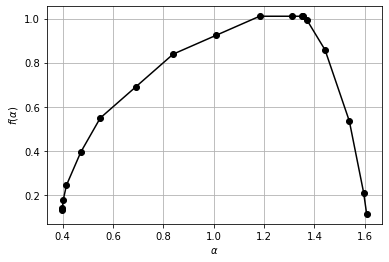


alpha_min = 0.398219, alpha_max = 1.60737, dalpha = 1.20915
h_min = 0.362788, h_max = 1.67701, dh = 1.31422

#################### Time series of February 2022 ####################



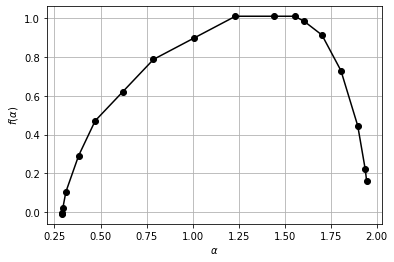


alpha_min = 0.292358, alpha_max = 1.9459, dalpha = 1.65354
h_min = 0.261395, h_max = 2.01836, dh = 1.75697

#################### Time series of March 2022 ####################



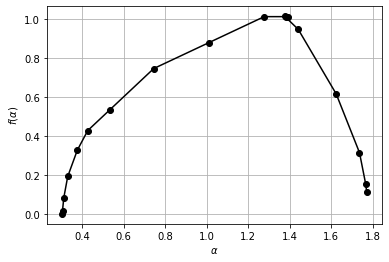


alpha_min = 0.303703, alpha_max = 1.77003, dalpha = 1.46633
h_min = 0.272487, h_max = 1.83962, dh = 1.56714



In [32]:
for i in range(0,len(df_pluvio_array)):
	#print(len(df_pluvio_array[i]))
	print("#################### Time series of {} ####################\n".format(month_array[i]))
	var_stats = getStats(df_pluvio_array[i])
	plotAlpha(var_stats)

**Descrição do código:**

As funções abaixo são utilizadas no cálculo de $γ_2$ para uma dada série temporal recebida como entrada.

In [33]:
def getDalpha(var_stats):
  return var_stats['LH_max'] - var_stats['LH_min'] 

def calc_gamma2(data):
  var_stats = getStats(data)
  dalpha = getDalpha(var_stats)
  return 2/3 * dalpha

## 2.5. Técnica Espectral de janelamento móvel

Descrição código:

As variáveis *win_initial_pos* e *win_size* definem, respectivamente, a posição inicial do janelamento para cada uma das séries temporais e o tamanho da janela. Dessa forma, considerou-se um tamanho de janela de $2^8$, ou seja, com o janelamento completo possuindo tamanho $2^8 * 4 = 1024$.

In [34]:
win_initial_pos = [3200,1250, 2000]
win_size = 2**8
win_label_offset = 50

**Descrição do código:**

A função abaixo (*'plot_st_wd'*) realiza a plotagem de uma série temporal com a definição do janelamento escolhido (Wa, Wb, Wc, Wd).

In [35]:
from matplotlib.patches import Rectangle

def plot_st_wd(dx, title, color, initialPos, win_size, axs):
  axs.set_title(title)
  #Série Temporal
  axs.plot(dx, color=color, linewidth=0.5, label=title, zorder=0)
  #Define limites no eixo x
  axs.set_xlim(0,len(dx))
  #Linha do 3σ
  axs.axhline(3*np.std(dx), label='3σ', color='purple', linestyle='dashed', linewidth=1.5)
  #Dados do janelamento
  win_labels = ['a', 'b', 'c', 'd']
  win_colors = ['tab:orange', 'tab:green', 'tab:blue', 'black']
  win_num = 4
  #Define os limites do eixo y
  y_min = min(dx)
  y_max = max(max(dx), 3*np.std(dx)) + 0.3
  delta_y = y_max - y_min

  for i in range(0,win_num):
    x = win_size*(i+1)  
    #Linhas do janelamento  
    axs.vlines(x = initialPos + x, ymin = y_min, ymax = y_max, color = 'k', linestyle='dashed', linewidth=2)
    #Labels do janelamento
    w_label_pos = initialPos + x - win_label_offset
    axs.text(w_label_pos, y_max, 'W{}'.format(win_labels[i]),
          horizontalalignment='right',
          verticalalignment='bottom',
          fontsize=12, color=win_colors[i])

  #Retângulo do janelamento  
  axs.add_patch( Rectangle((initialPos, y_min),
                        win_size*4, delta_y,
                        facecolor ='none', 
                        edgecolor ='k',
                        linewidth = 3) )  

  axs.set_xlabel('time steps (n)')
  axs.set_ylabel('A(n)')
  axs.legend(loc ="center left", bbox_to_anchor = (1, 0, 0.5, 1), fontsize='large')

**Descrição do código:**

O código abaixo realiza a plotagem das três séries temporais geradas neste trabalho, com o respectivo janelamento (Wa, Wb, Wc, Wd) definido de forma a apresentar padrão extremo na Wd.

Para as séries temporais com β = 0.2 e 1.0, considerou-se padrão extremo os eventos que superaram a linha do 3σ. Já para a série temporal com β = 2.0, o padrão extremo analisado foi o pico da série. 

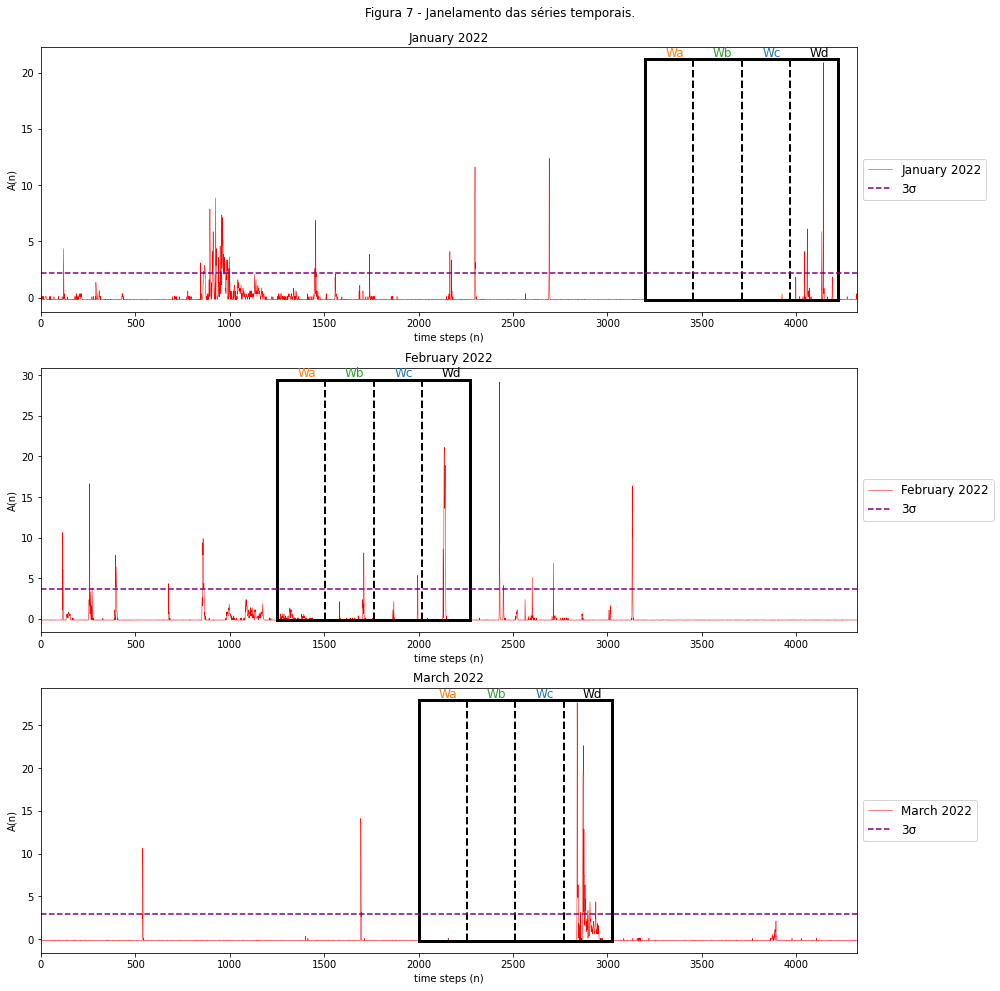

In [36]:
fig, axs = plt.subplots(3, 1, figsize=(14,14)) #rows = 3, cols = 1

for i in range(0,len(df_pluvio_array)):
  plot_st_wd(df_pluvio_array[i], month_array[i], 'red', win_initial_pos[i], win_size, axs[i])

fig.suptitle("Figura 7 - Janelamento das séries temporais.")

fig.tight_layout()
fig.subplots_adjust(top=0.94)

plt.show()

# 3.Resultados

Essa seção apresenta os resultados obtidos com a aplicação da técnica espectral de janelamento móvel nas 3 séries temporais analisadas neste trabalho, com foco nos eventos extremos de precipitação que ocorreram no período.

**Descrição do código:**

O código abaixo calcula os valores de $γ_1$ e $γ_2$ para cada uma das **janelas** definidas anteriormente. O resultado é armazenado em um DataFrame nomeado *'df_window'*, que é impresso abaixo.

In [37]:
st = []
st_name = []
gamma1 = []
gamma2 = []
win = []
win_labels = ['a', 'b', 'c', 'd']
color = []
win_colors = ['tab:orange', 'tab:green', 'tab:blue', 'black']
marker = []
marker_labels = ['o', 's', '^']

#Itera sobre as séries temporais
for i in range(0, len(df_pluvio_array)):
  #Itera sobre as janelas
  for j in range(0,len(win_labels)):
    st_item = df_pluvio_array[i][win_initial_pos[i] + j*win_size : win_initial_pos[i] + (j+1)*win_size]
    st.append(st_item)
    win.append(win_labels[j])
    st_name.append(month_array[i])
    marker.append(marker_labels[i])
    color.append(win_colors[j])
    gamma1.append(calc_gamma1(st_item))
    gamma2.append(calc_gamma2(st_item))

#Criação do DataFrame do Janelamento
dict = {
    'st': st,
    'st_name': st_name,   
    'win': win,
    'gamma1': gamma1,
    'gamma2': gamma2,
    'marker': marker,
    'color': color
    } 
df_window = pd.DataFrame(data=dict) 
df_window.head(12)

,st,st_name,win,gamma1,gamma2,marker,color
0,"[-0.1259620289653839, -0.13076542005648362, -0...",January 2022,a,0.313493,0.314193,o,tab:orange
1,"[-0.12788652216727306, -0.1511124836040325, -0...",January 2022,b,0.174486,0.393394,o,tab:green
2,"[-0.1408454087138944, -0.13560237480849263, -0...",January 2022,c,0.197648,0.317984,o,tab:blue
3,"[-0.14246155048696157, -0.13773843519516124, -...",January 2022,d,0.320467,1.775234,o,black
4,"[-0.1414761527530258, -0.16358508628826987, -0...",February 2022,a,0.628948,0.820098,s,tab:orange
5,"[-0.1508276642236827, -0.14538428740957943, -0...",February 2022,b,0.462897,0.930548,s,tab:green
6,"[-0.1603868620830736, -0.1717933790272093, -0....",February 2022,c,0.452249,1.071405,s,tab:blue
7,"[-0.15025626414986987, -0.15324217661254763, -...",February 2022,d,0.984797,1.434479,s,black
8,"[-0.17440662379484337, -0.1418054502892485, -0...",March 2022,a,0.091288,0.777001,^,tab:orange
9,"[-0.13827517051492205, -0.12737519665567332, -...",March 2022,b,0.082109,0.476113,^,tab:green


**Descrição do código:**

O código abaixo apresenta o Domínio Espectral ($γ_1$ x $γ_2$) para o janelamento de cada uma das três séries temporais geradas neste trabalho.

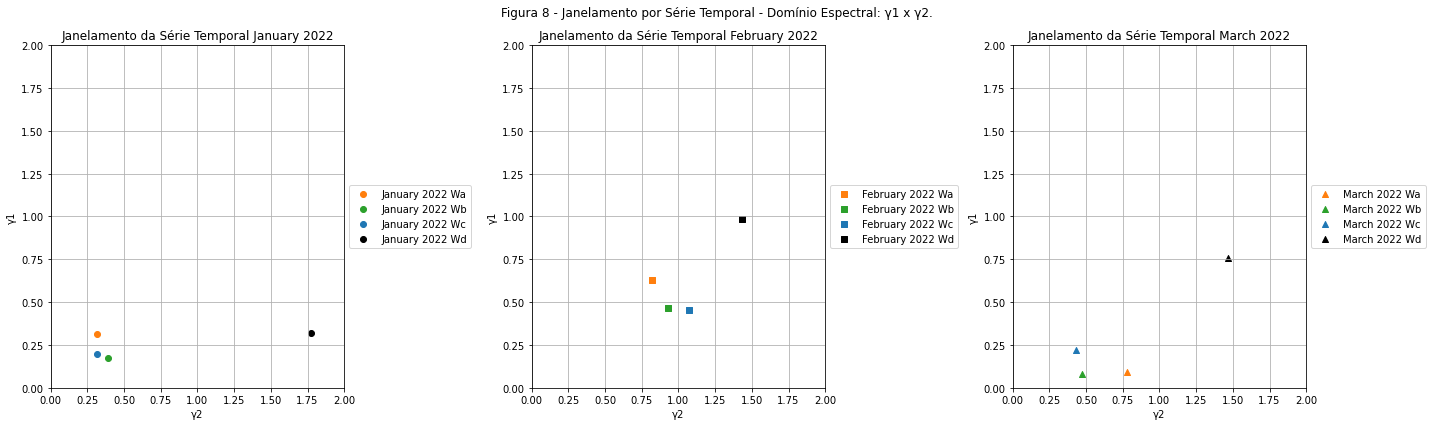

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(20,6)) #rows = 1, cols = 3

for i in range(0, len(df_pluvio_array)):
  dx = df_window.loc[df_window['st_name'] == month_array[i]]
  for index, row in dx.iterrows():
    axs[i].scatter(x=row.gamma2, y=row.gamma1, label='{} W{}'.format(row.st_name, row.win), marker=row.marker, color=row.color)

  axs[i].set_xlim(0,2)
  axs[i].set_ylim(0,2)
  axs[i].set_xlabel('γ2')
  axs[i].set_ylabel('γ1')
  axs[i].set_title('Janelamento da Série Temporal {}'.format(month_array[i]))
  axs[i].grid(True)
  axs[i].legend(loc ="center left", bbox_to_anchor = (1, 0, 0.5, 1))

fig.suptitle("Figura 8 - Janelamento por Série Temporal - Domínio Espectral: γ1 x γ2.")

fig.tight_layout()
fig.subplots_adjust(top=0.89)

plt.show()

**Descrição do código:**

Uma visualização alternativa é a plotagem conjunta do domínio espectral para as janelas de todas as séries analisadas. De forma a facilitar a interpretação dos dados, os pontos de uma mesma série possuem um mesmo marcador, e os pontos de uma determinada janela possuem uma mesma cor para todas as séries, sendo que os marcadores de cor preta são referentes a janela Wd.

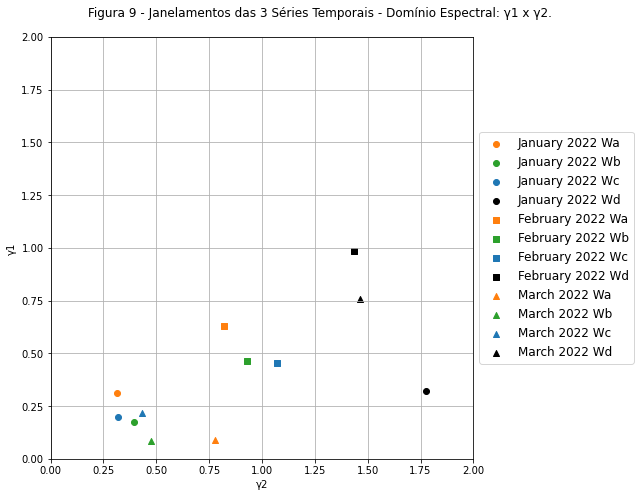

In [39]:
fig, axs = plt.subplots(figsize=(9,7))

for i in range(0, len(df_window)):
  axs.scatter(x=df_window.gamma2[i], y=df_window.gamma1[i], label='{} W{}'.format(df_window.st_name[i], df_window.win[i]), marker=df_window.marker[i], c=df_window.color[i])

axs.set_xlim(0,2)
axs.set_ylim(0,2)
axs.set_xlabel('γ2')
axs.set_ylabel('γ1')

axs.grid(True)

axs.legend(loc ="center left", bbox_to_anchor = (1, 0, 0.5, 1), fontsize='large')

fig.suptitle("Figura 9 - Janelamentos das 3 Séries Temporais - Domínio Espectral: γ1 x γ2.")

fig.tight_layout()
fig.subplots_adjust(top=0.92)

plt.show()

**Análise:**

Percebe-se que as janelas **Wa**, **Wb** e **Wc** que precedem eventos extremos,apresentaram valores de $γ_1$ e $γ_2$ menores do que 1, enquanto os eventos extremos identificados em **Wd**, apresentaram sempre $γ_2$ com valores maiores que 1. Além disso, é possível notar também que tanto os valores de $γ_1$ quanto os valores de $γ_2$ foram maiores na janela **Wd** em relação às janelas anteriores. Deste modo, percebe-se uma clara divisão entre o agrupamento de **Wa**, **Wb** e **Wc** para os elementos **Wd**.

Fato interessante, observou-se que na ST de fevereiro de 2022, as janelas **Wb** e **Wc** também apresentaram valores de $γ_2$ ligeiramente maiores que 1; precede que, ao observar a série temporal, ambas janelas apresentam valores de chuva  acima de 3 σ, o que identificaria, também, possível evento extremo.

As distâncias de **Wa**, **Wb** e **Wc** também são pequenas entre si, porém maiores para **Wd**, apresentando um possível padrão que pode ser utilizado para classificação de eventos extremos na série temporal de dados utilizada. Necessária a verificação de uma série maior para validação e também a aplicação do método com a validação dos eventos extremos confirmados.

# 4.Conclusões e Perspectivas Futuras

Eventos extremos de precipitação marcaram o início do ano de 2022 da cidade de Petrópolis com mortes e destruição. Técnicas de análise espectral associadas à ferramentas de Inteligência Artificial poderiam auxiliar na previsão de eventos extremos como estes, mitigando os impactos e salvando vidas. 

Este trabalho fez uma análise no domínio da frequência a partir de séries temporais de precipitação, com o objetivo de identificar as características e possíveis padrões espectrais inerentes a eventos extremos.
Dados de chuva provenientes de uma estação do Cemaden foram pré-processados para normalização e homogeinização da frequência (10 minutos). Como resultado, três séries temporais foram obtidas - referentes aos meses de janeiro, fevereiro e março de 2022, respectivamente -, cada uma com pouco mais de quatro mil valores observacionais. 

Como primeiro passo, foram analisadas as características de kurtosis e skewness de cada série temporal. Através do gráfico de Cullen-Frey, foi possível identificar que todas as séries analisadas aproximam-se de uma distribuição gamma, com uma grande maioria das frequências concentrada nos valores zerados. Comportamento este absolutamente esperado para uma série de precipitação, considerando que realmente não há chuva em um dado ponto na maior parte do tempo.

Em um segundo passo, foi feita a caracterização das séries através do espectro de potências utilizando as metodologias do Power Spectrum Density (PSD) e Detrended Fluctuation Analysis (DFA). Os valores resultantes de $\beta$ e $\alpha$ foram próximos nos três casos, com um valor de $\beta$ próximo ao ruído rosa ($\beta = 1.0$). Também foi feita uma caracterização do espectro multifractal utilizando o MFSS (Multifractal Singularity Spectrum), e analisando os valores de $\Delta \alpha$ em cada caso.

Por fim, foi aplicada a técnica espectral de janelamento móvel analisando especificamente o evento extremo ocorrido em cada um dos meses abordados. Nas três séries analisadas, a janela contendo o evento extremo (Wd) obteve os maiores valores de $γ1$ e $γ2$, mostrando uma clara segregação em relação às janelas anteriores. Resultado este que sugere um possível padrão para classificação de eventos extremos dentro do contexto abordado.

Como continuação do trabalho, pretendemos associar os resultados da análise espectral à ferramentas de Inteligência Artificial, como Machine Learning e Redes Neurais, com o intuito de fazer a classificação e previsão de eventos extremos de precipitação. Há o interesse também de agregar dados de umidade do solo nas pesquisas. 

# Apêndice

**Comparação com o Artigo de Referência: "Flood Prediction Using Time Series Data Mining." [7]**

A técnica utilizada em [7] é bastante diferente da utilizada por este trabalho. Em [7] são utilizadas metodologias como mineração de dados e métodos de reconstrução de espaço de fases para revelar padrões preditivos ocultos de eventos futuros em séries temporais não estacionárias e não lineares. Por outro lado, este trabalho realiza uma análise espectral de séries temporais de precipitação através de técnica espectral de janelamento móvel.

Além disso, em [7] são utilizadas dados de vazão de rio ($m^3/s$), enquanto que neste trabalho são utilizados dados de precipitação ($mm$).



# Referências

[1] Petrópolis vive maior catástrofe natural de sua história. UOL Notícias, 2022. Available at: <https://noticias.uol.com.br/ultimas-noticias/deutschewelle/2022/02/21/petropolis-vive-maior-catastrofe-natural-de-sua-historia.htm>. Accessed on: 08 Jun, 2022.

[2] Mapa Interativo. Cemaden, 2022. Available at: <http://www2.cemaden.gov.br/mapainterativo>. Accessed on: 30 May, 2022.

[3] Satriano, N. G1 Rio, 2022. Available at: <https://g1.globo.com/rj/rio-de-janeiro/noticia/2022/02/20/tragedia-em-petropolis-maior-registrada-na-historia-o-municipio.ghtml>. Accessed on: 08 Jun, 2022.

[4] Campos, A. C. Agência Brasil, 2022. Available at: <https://agenciabrasil.ebc.com.br/geral/noticia/2022-02/tragedia-em-petropolis-e-maior-da-historia-da-cidade>. Accessed on: 08 Jun, 2022.

[5] Rocha, M. Folha de S.Paulo, 2022. Available at: <https://www1.folha.uol.com.br/cotidiano/2022/02/numero-de-mortos-em-petropolis-chega-a-223-ainda-ha-20-desaparecidos.shtml>. Accessed on: 08 Jun, 2022.

[6] Mortos em Petrópolis chegam a 231, na tragédia mais fatal da história da cidade. Isto É Dinheiro, 2022. Available at: <https://www.istoedinheiro.com.br/mortos-em-petropolis-chegam-a-231-na-tragedia-mais-fatal-da-historia-da-cidade>. Accessed on: 08 Jun, 2022.

[7] Damle, Chaitanya, and Ali Yalcin. “Flood Prediction Using Time Series Data Mining.” Journal of Hydrology, vol. 333, no. 2-4, Feb. 2007, pp. 305–316, 10.1016/j.jhydrol.2006.09.001. Accessed on: 07 Jun, 2022.

